<a href="https://colab.research.google.com/github/dannner66/Szakdoga/blob/main/train_schedule_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [210]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder #sklearn

from xgboost import XGBRegressor #xgboost
from sklearn.metrics import mean_squared_error,mean_absolute_error
import matplotlib.pyplot as plt #matplotlib
from xgboost import plot_tree
import xgboost as xgb

from matplotlib.pylab import rcParams
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import KFold
import numpy as np #numpy
from sklearn.model_selection import train_test_split
import joblib
from sklearn.pipeline import make_pipeline


# Data Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [211]:
!gdown 1k-FunUld66SiY3cPn6sDBzzmB0qwlItg

Downloading...
From: https://drive.google.com/uc?id=1k-FunUld66SiY3cPn6sDBzzmB0qwlItg
To: /content/sample.xlsx
100% 31.5k/31.5k [00:00<00:00, 40.4MB/s]


In [212]:
pd.set_option('display.max_columns',120)
pd.set_option('display.max_rows',120)

In [213]:
dataset = pd.read_excel('/content/sample.xlsx')
dataset.head()

,train_id,terv_date,terv_ind,terv_erk,ind_stat_terv,ind_nev_terv,erk_stat_terv,erk__terv,teny_ind,teny_erk,rakom_tom,vonathossz,vontat_mode,vonatnem,ind_stat_teny,ind_teny,erk_stat_teny,erk_teny
0,79877,2021-04-11 02:00:00,1970-01-01 11:00:00,1970-01-01 11:09:00,13771,Szajol,13748,Szolnok,2021-04-11 13:10:00,2021-04-11 13:00:00,0,18,NaN,M,13771,Szajol,13748,Szolnok
1,102865,2021-09-21 00:00:00,1970-01-01 18:00:00,1970-01-01 18:52:00,10074,Rákos,1081,Bicske,2021-09-21 19:41:00,2021-09-22 02:20:00,0,270,NaN,T,10074,Rákos,1081,Bicske
2,93885,2021-07-23 02:00:00,1970-01-01 23:00:00,1970-01-01 23:16:00,13847,Karcag,13862,Püspökladány,2021-07-23 22:21:00,2021-07-23 21:35:00,480000,258,NaN,T,13847,Karcag,13862,Püspökladány
3,119226,2021-12-19 00:00:00,1970-01-01 10:00:00,1970-01-01 16:14:00,13722,Cegléd,13821,Kisújszállás,2021-12-19 21:14:00,2021-12-20 13:08:00,600000,480,tmDiesel,T,13722,Cegléd,13821,Kisújszállás
4,125506,2022-01-30 00:00:00,1970-01-01 17:30:00,1970-01-01 21:26:00,3285,Szabadbattyán,4648,Uzsabánya,2022-01-30 16:16:00,2022-01-31 12:05:00,0,300,tmDiesel,T,3285,Szabadbattyán,4648,Uzsabánya


In [214]:
dataset['train_id'] = dataset['train_id'].astype(str)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   train_id       200 non-null    object
 1   terv_date      200 non-null    object
 2   terv_ind       200 non-null    object
 3   terv_erk       200 non-null    object
 4   ind_stat_terv  200 non-null    int64 
 5   ind_nev_terv   200 non-null    object
 6   erk_stat_terv  200 non-null    int64 
 7   erk__terv      200 non-null    object
 8   teny_ind       200 non-null    object
 9   teny_erk       200 non-null    object
 10  rakom_tom      200 non-null    int64 
 11  vonathossz     200 non-null    int64 
 12  vontat_mode    91 non-null     object
 13  vonatnem       200 non-null    object
 14  ind_stat_teny  200 non-null    int64 
 15  ind_teny       200 non-null    object
 16  erk_stat_teny  200 non-null    int64 
 17  erk_teny       200 non-null    object
dtypes: int64(6), object(12)
memory

In [215]:
#print(dataset['terv_ind'])
def concat_terv(data):

  for idx, row in data.iterrows():
        tmp_date = str(data.at[idx, 'terv_date']).split(" ")[0] + ' ' + str(data.at[idx, 'terv_ind']).split(" ")[1]
        data.at[idx, 'terv_ind'] = pd.to_datetime(tmp_date)
        tmp_date = str(data.at[idx, 'terv_date']).split(" ")[0] + ' ' + str(data.at[idx, 'terv_erk']).split(" ")[1]
        data.at[idx, 'terv_erk'] = pd.to_datetime(tmp_date)
  return data

In [216]:
concat_terv(dataset)

,train_id,terv_date,terv_ind,terv_erk,ind_stat_terv,ind_nev_terv,erk_stat_terv,erk__terv,teny_ind,teny_erk,rakom_tom,vonathossz,vontat_mode,vonatnem,ind_stat_teny,ind_teny,erk_stat_teny,erk_teny
0,79877,2021-04-11 02:00:00,2021-04-11 11:00:00,2021-04-11 11:09:00,13771,Szajol,13748,Szolnok,2021-04-11 13:10:00,2021-04-11 13:00:00,0,18,NaN,M,13771,Szajol,13748,Szolnok
1,102865,2021-09-21 00:00:00,2021-09-21 18:00:00,2021-09-21 18:52:00,10074,Rákos,1081,Bicske,2021-09-21 19:41:00,2021-09-22 02:20:00,0,270,NaN,T,10074,Rákos,1081,Bicske
2,93885,2021-07-23 02:00:00,2021-07-23 23:00:00,2021-07-23 23:16:00,13847,Karcag,13862,Püspökladány,2021-07-23 22:21:00,2021-07-23 21:35:00,480000,258,NaN,T,13847,Karcag,13862,Püspökladány
3,119226,2021-12-19 00:00:00,2021-12-19 10:00:00,2021-12-19 16:14:00,13722,Cegléd,13821,Kisújszállás,2021-12-19 21:14:00,2021-12-20 13:08:00,600000,480,tmDiesel,T,13722,Cegléd,13821,Kisújszállás
4,125506,2022-01-30 00:00:00,2022-01-30 17:30:00,2022-01-30 21:26:00,3285,Szabadbattyán,4648,Uzsabánya,2022-01-30 16:16:00,2022-01-31 12:05:00,0,300,tmDiesel,T,3285,Szabadbattyán,4648,Uzsabánya
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,207788,2023-06-29 00:00:00,2023-06-29 11:00:00,2023-06-29 11:30:00,11445,Szerencs,13284,Tállya,2023-06-29 09:20:00,2023-06-29 10:14:00,0,411,NaN,T,11445,Szerencs,13284,Tállya
196,209006,2023-07-15 00:00:00,2023-07-15 16:17:00,2023-07-15 16:57:00,17137,Kiskunfélegyháza,16311,Kiskunhalas,2023-07-15 20:07:00,2023-07-15 21:32:00,0,18,NaN,M,17137,Kiskunfélegyháza,16311,Kiskunhalas
197,223395,2023-12-15 00:00:00,2023-12-15 01:00:00,2023-12-15 01:26:00,10025,Ferencváros,10082,Rákosrendező,2023-12-14 23:08:00,2023-12-15 00:21:00,0,458,tmElectric,T,10025,Ferencváros,10082,Rákosrendező
198,227451,2024-02-13 00:00:00,2024-02-13 16:00:00,2024-02-13 16:55:00,11395,Felsőzsolca,11296,Füzesabony,2024-02-13 15:41:00,2024-02-13 17:19:00,0,20,tmElectric,M,11395,Felsőzsolca,11296,Füzesabony


In [217]:
dataset.drop('ind_stat_teny', axis=1, inplace=True)
dataset.drop('ind_stat_terv', axis=1, inplace=True)
dataset.drop('erk_stat_teny', axis=1, inplace=True)
dataset.drop('erk_stat_terv', axis=1, inplace=True)
dataset.drop('terv_date', axis=1, inplace=True)
dataset.drop('train_id', axis=1, inplace=True)

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   terv_ind      200 non-null    object
 1   terv_erk      200 non-null    object
 2   ind_nev_terv  200 non-null    object
 3   erk__terv     200 non-null    object
 4   teny_ind      200 non-null    object
 5   teny_erk      200 non-null    object
 6   rakom_tom     200 non-null    int64 
 7   vonathossz    200 non-null    int64 
 8   vontat_mode   91 non-null     object
 9   vonatnem      200 non-null    object
 10  ind_teny      200 non-null    object
 11  erk_teny      200 non-null    object
dtypes: int64(2), object(10)
memory usage: 18.9+ KB


In [218]:
dataset[dataset['terv_ind'] == dataset['terv_erk']]

,terv_ind,terv_erk,ind_nev_terv,erk__terv,teny_ind,teny_erk,rakom_tom,vonathossz,vontat_mode,vonatnem,ind_teny,erk_teny


In [219]:
dataset = dataset[dataset['teny_ind'] != dataset['teny_erk']].copy()

In [220]:


def extract_date(data):

    data['terv_ind'] = pd.to_datetime(data['terv_ind'],format="%Y-%m-%d %H:%M:%S")
    data['terv_ind_Year'] = data.terv_ind.dt.year
    data['terv_ind_Month'] = data.terv_ind.dt.month
    data['terv_ind_Day'] = data.terv_ind.dt.day
    data['terv_ind_Hour'] = data.terv_ind.dt.hour
    data['terv_ind_Minute'] = data.terv_ind.dt.minute
    data['terv_ind_Second'] = data.terv_ind.dt.second
    data['terv_ind_WeekOfYear'] = data.terv_ind.dt.isocalendar().week

    data['terv_erk'] = pd.to_datetime(data['terv_erk'],format="%Y-%m-%d %H:%M:%S")
    data['terv_erk_Year'] = data.terv_erk.dt.year
    data['terv_erk_Month'] = data.terv_erk.dt.month
    data['terv_erk_Day'] = data.terv_erk.dt.day
    data['terv_erk_Hour'] = data.terv_erk.dt.hour
    data['terv_erk_Minute'] = data.terv_erk.dt.minute
    data['terv_erk_Second'] = data.terv_erk.dt.second
    data['terv_erk_WeekOfYear'] = data.terv_erk.dt.isocalendar().week

    data['teny_ind'] = pd.to_datetime(data['teny_ind'],format="%Y-%m-%d %H:%M:%S")
    data['teny_ind_Year'] = data.teny_ind.dt.year
    data['teny_ind_Month'] = data.teny_ind.dt.month
    data['teny_ind_Day'] = data.teny_ind.dt.day
    data['teny_ind_Hour'] = data.teny_ind.dt.hour
    data['teny_ind_Minute'] = data.teny_ind.dt.minute
    data['teny_ind_Second'] = data.teny_ind.dt.second
    data['teny_ind_WeekOfYear'] = data.teny_ind.dt.isocalendar().week

    data['teny_erk'] = pd.to_datetime(data['teny_erk'],format="%Y-%m-%d %H:%M:%S")
    data['teny_erk_Year'] = data.teny_erk.dt.year
    data['teny_erk_Month'] = data.teny_erk.dt.month
    data['teny_erk_Day'] = data.teny_erk.dt.day
    data['teny_erk_Hour'] = data.teny_erk.dt.hour
    data['teny_erk_Minute'] = data.teny_erk.dt.minute
    data['teny_erk_Second'] = data.teny_erk.dt.second
    data['teny_erk_WeekOfYear'] = data.teny_erk.dt.isocalendar().week
    #data.drop('terv_ind', axis=1, inplace=True)
    #data.drop('terv_erk', axis=1, inplace=True)
    #data.drop('teny_ind', axis=1, inplace=True)
    #data.drop('teny_erk', axis=1, inplace=True)
    #data.drop('terv_date', axis=1, inplace=True)

In [221]:
extract_date(dataset)

In [222]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 40 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   terv_ind             200 non-null    datetime64[ns]
 1   terv_erk             200 non-null    datetime64[ns]
 2   ind_nev_terv         200 non-null    object        
 3   erk__terv            200 non-null    object        
 4   teny_ind             200 non-null    datetime64[ns]
 5   teny_erk             200 non-null    datetime64[ns]
 6   rakom_tom            200 non-null    int64         
 7   vonathossz           200 non-null    int64         
 8   vontat_mode          91 non-null     object        
 9   vonatnem             200 non-null    object        
 10  ind_teny             200 non-null    object        
 11  erk_teny             200 non-null    object        
 12  terv_ind_Year        200 non-null    int32         
 13  terv_ind_Month       200 non-null  

In [223]:
dataset = dataset[dataset.rakom_tom >= 0].copy()
dataset = dataset[dataset.vonathossz >= 0].copy()

dataset[dataset.terv_erk == ""]

,terv_ind,terv_erk,ind_nev_terv,erk__terv,teny_ind,teny_erk,rakom_tom,vonathossz,vontat_mode,vonatnem,ind_teny,erk_teny,terv_ind_Year,terv_ind_Month,terv_ind_Day,terv_ind_Hour,terv_ind_Minute,terv_ind_Second,terv_ind_WeekOfYear,terv_erk_Year,terv_erk_Month,terv_erk_Day,terv_erk_Hour,terv_erk_Minute,terv_erk_Second,terv_erk_WeekOfYear,teny_ind_Year,teny_ind_Month,teny_ind_Day,teny_ind_Hour,teny_ind_Minute,teny_ind_Second,teny_ind_WeekOfYear,teny_erk_Year,teny_erk_Month,teny_erk_Day,teny_erk_Hour,teny_erk_Minute,teny_erk_Second,teny_erk_WeekOfYear


In [224]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 40 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   terv_ind             200 non-null    datetime64[ns]
 1   terv_erk             200 non-null    datetime64[ns]
 2   ind_nev_terv         200 non-null    object        
 3   erk__terv            200 non-null    object        
 4   teny_ind             200 non-null    datetime64[ns]
 5   teny_erk             200 non-null    datetime64[ns]
 6   rakom_tom            200 non-null    int64         
 7   vonathossz           200 non-null    int64         
 8   vontat_mode          91 non-null     object        
 9   vonatnem             200 non-null    object        
 10  ind_teny             200 non-null    object        
 11  erk_teny             200 non-null    object        
 12  terv_ind_Year        200 non-null    int32         
 13  terv_ind_Month       200 non-null  

In [225]:
def duration(data):
    # Calculate the timedeltas
    travel_time_terv = data['terv_erk'] - data['terv_ind']
    travel_time_teny = data['teny_erk'] - data['teny_ind']

    # Calculate days, hours, and minutes for terv
    data['travel_time_terv'] = (travel_time_terv.dt.seconds // 3600)*60 + (travel_time_terv.dt.seconds % 3600) // 60
    # Calculate days, hours, and minutes for teny (if needed)
    data['travel_time_teny'] = (travel_time_teny.dt.seconds // 3600)*60 + (travel_time_teny.dt.seconds % 3600) // 60
    return data


In [226]:
import datetime
def arrival_repair(data):

    tmp_str_date = ''
    for idx, row in data.iterrows():
        if row['terv_erk'] <= row['terv_ind']:
            data.at[idx, 'terv_erk'] += datetime.timedelta(days=1)
        tmp_str_date = str(data.at[idx,'terv_erk_Year']) +'-'+ str(data.at[idx,'terv_erk_Month']) + '-' + str(data.at[idx,'terv_erk_Day']) + ' ' + str(data.at[idx,'terv_erk_Hour']) + ':' + str(data.at[idx,'terv_erk_Minute']) + ':' + str(data.at[idx,'terv_erk_Second'])
        data.at[idx,  'terv_erk'] = pd.to_datetime(tmp_str_date,dayfirst=True)
        if row['teny_erk'] <= row['teny_ind']:
            data.at[idx, 'teny_erk'] += datetime.timedelta(days=1)
        tmp_str_date = str(data.at[idx,'teny_erk_Year']) +'-'+ str(data.at[idx,'teny_erk_Month']) + '-' + str(data.at[idx,'teny_erk_Day']) + ' ' + str(data.at[idx,'teny_erk_Hour']) + ':' + str(data.at[idx,'teny_erk_Minute']) + ':' + str(data.at[idx,'teny_erk_Second'])
        data.at[idx,  'teny_erk'] = pd.to_datetime(tmp_str_date, dayfirst=True)

    return data

In [227]:
dataset

,terv_ind,terv_erk,ind_nev_terv,erk__terv,teny_ind,teny_erk,rakom_tom,vonathossz,vontat_mode,vonatnem,ind_teny,erk_teny,terv_ind_Year,terv_ind_Month,terv_ind_Day,terv_ind_Hour,terv_ind_Minute,terv_ind_Second,terv_ind_WeekOfYear,terv_erk_Year,terv_erk_Month,terv_erk_Day,terv_erk_Hour,terv_erk_Minute,terv_erk_Second,terv_erk_WeekOfYear,teny_ind_Year,teny_ind_Month,teny_ind_Day,teny_ind_Hour,teny_ind_Minute,teny_ind_Second,teny_ind_WeekOfYear,teny_erk_Year,teny_erk_Month,teny_erk_Day,teny_erk_Hour,teny_erk_Minute,teny_erk_Second,teny_erk_WeekOfYear
0,2021-04-11 11:00:00,2021-04-11 11:09:00,Szajol,Szolnok,2021-04-11 13:10:00,2021-04-11 13:00:00,0,18,NaN,M,Szajol,Szolnok,2021,4,11,11,0,0,14,2021,4,11,11,9,0,14,2021,4,11,13,10,0,14,2021,4,11,13,0,0,14
1,2021-09-21 18:00:00,2021-09-21 18:52:00,Rákos,Bicske,2021-09-21 19:41:00,2021-09-22 02:20:00,0,270,NaN,T,Rákos,Bicske,2021,9,21,18,0,0,38,2021,9,21,18,52,0,38,2021,9,21,19,41,0,38,2021,9,22,2,20,0,38
2,2021-07-23 23:00:00,2021-07-23 23:16:00,Karcag,Püspökladány,2021-07-23 22:21:00,2021-07-23 21:35:00,480000,258,NaN,T,Karcag,Püspökladány,2021,7,23,23,0,0,29,2021,7,23,23,16,0,29,2021,7,23,22,21,0,29,2021,7,23,21,35,0,29
3,2021-12-19 10:00:00,2021-12-19 16:14:00,Cegléd,Kisújszállás,2021-12-19 21:14:00,2021-12-20 13:08:00,600000,480,tmDiesel,T,Cegléd,Kisújszállás,2021,12,19,10,0,0,50,2021,12,19,16,14,0,50,2021,12,19,21,14,0,50,2021,12,20,13,8,0,51
4,2022-01-30 17:30:00,2022-01-30 21:26:00,Szabadbattyán,Uzsabánya,2022-01-30 16:16:00,2022-01-31 12:05:00,0,300,tmDiesel,T,Szabadbattyán,Uzsabánya,2022,1,30,17,30,0,4,2022,1,30,21,26,0,4,2022,1,30,16,16,0,4,2022,1,31,12,5,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2023-06-29 11:00:00,2023-06-29 11:30:00,Szerencs,Tállya,2023-06-29 09:20:00,2023-06-29 10:14:00,0,411,NaN,T,Szerencs,Tállya,2023,6,29,11,0,0,26,2023,6,29,11,30,0,26,2023,6,29,9,20,0,26,2023,6,29,10,14,0,26
196,2023-07-15 16:17:00,2023-07-15 16:57:00,Kiskunfélegyháza,Kiskunhalas,2023-07-15 20:07:00,2023-07-15 21:32:00,0,18,NaN,M,Kiskunfélegyháza,Kiskunhalas,2023,7,15,16,17,0,28,2023,7,15,16,57,0,28,2023,7,15,20,7,0,28,2023,7,15,21,32,0,28
197,2023-12-15 01:00:00,2023-12-15 01:26:00,Ferencváros,Rákosrendező,2023-12-14 23:08:00,2023-12-15 00:21:00,0,458,tmElectric,T,Ferencváros,Rákosrendező,2023,12,15,1,0,0,50,2023,12,15,1,26,0,50,2023,12,14,23,8,0,50,2023,12,15,0,21,0,50
198,2024-02-13 16:00:00,2024-02-13 16:55:00,Felsőzsolca,Füzesabony,2024-02-13 15:41:00,2024-02-13 17:19:00,0,20,tmElectric,M,Felsőzsolca,Füzesabony,2024,2,13,16,0,0,7,2024,2,13,16,55,0,7,2024,2,13,15,41,0,7,2024,2,13,17,19,0,7


In [228]:
dataset_min_change = dataset.copy()
arrival_repair(dataset)

<ipython-input-226-50dd1000db31>:9: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  data.at[idx,  'terv_erk'] = pd.to_datetime(tmp_str_date,dayfirst=True)
<ipython-input-226-50dd1000db31>:13: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  data.at[idx,  'teny_erk'] = pd.to_datetime(tmp_str_date, dayfirst=True)


,terv_ind,terv_erk,ind_nev_terv,erk__terv,teny_ind,teny_erk,rakom_tom,vonathossz,vontat_mode,vonatnem,ind_teny,erk_teny,terv_ind_Year,terv_ind_Month,terv_ind_Day,terv_ind_Hour,terv_ind_Minute,terv_ind_Second,terv_ind_WeekOfYear,terv_erk_Year,terv_erk_Month,terv_erk_Day,terv_erk_Hour,terv_erk_Minute,terv_erk_Second,terv_erk_WeekOfYear,teny_ind_Year,teny_ind_Month,teny_ind_Day,teny_ind_Hour,teny_ind_Minute,teny_ind_Second,teny_ind_WeekOfYear,teny_erk_Year,teny_erk_Month,teny_erk_Day,teny_erk_Hour,teny_erk_Minute,teny_erk_Second,teny_erk_WeekOfYear
0,2021-04-11 11:00:00,2021-11-04 11:09:00,Szajol,Szolnok,2021-04-11 13:10:00,2021-11-04 13:00:00,0,18,NaN,M,Szajol,Szolnok,2021,4,11,11,0,0,14,2021,4,11,11,9,0,14,2021,4,11,13,10,0,14,2021,4,11,13,0,0,14
1,2021-09-21 18:00:00,2021-09-21 18:52:00,Rákos,Bicske,2021-09-21 19:41:00,2021-09-22 02:20:00,0,270,NaN,T,Rákos,Bicske,2021,9,21,18,0,0,38,2021,9,21,18,52,0,38,2021,9,21,19,41,0,38,2021,9,22,2,20,0,38
2,2021-07-23 23:00:00,2021-07-23 23:16:00,Karcag,Püspökladány,2021-07-23 22:21:00,2021-07-23 21:35:00,480000,258,NaN,T,Karcag,Püspökladány,2021,7,23,23,0,0,29,2021,7,23,23,16,0,29,2021,7,23,22,21,0,29,2021,7,23,21,35,0,29
3,2021-12-19 10:00:00,2021-12-19 16:14:00,Cegléd,Kisújszállás,2021-12-19 21:14:00,2021-12-20 13:08:00,600000,480,tmDiesel,T,Cegléd,Kisújszállás,2021,12,19,10,0,0,50,2021,12,19,16,14,0,50,2021,12,19,21,14,0,50,2021,12,20,13,8,0,51
4,2022-01-30 17:30:00,2022-01-30 21:26:00,Szabadbattyán,Uzsabánya,2022-01-30 16:16:00,2022-01-31 12:05:00,0,300,tmDiesel,T,Szabadbattyán,Uzsabánya,2022,1,30,17,30,0,4,2022,1,30,21,26,0,4,2022,1,30,16,16,0,4,2022,1,31,12,5,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2023-06-29 11:00:00,2023-06-29 11:30:00,Szerencs,Tállya,2023-06-29 09:20:00,2023-06-29 10:14:00,0,411,NaN,T,Szerencs,Tállya,2023,6,29,11,0,0,26,2023,6,29,11,30,0,26,2023,6,29,9,20,0,26,2023,6,29,10,14,0,26
196,2023-07-15 16:17:00,2023-07-15 16:57:00,Kiskunfélegyháza,Kiskunhalas,2023-07-15 20:07:00,2023-07-15 21:32:00,0,18,NaN,M,Kiskunfélegyháza,Kiskunhalas,2023,7,15,16,17,0,28,2023,7,15,16,57,0,28,2023,7,15,20,7,0,28,2023,7,15,21,32,0,28
197,2023-12-15 01:00:00,2023-12-15 01:26:00,Ferencváros,Rákosrendező,2023-12-14 23:08:00,2023-12-15 00:21:00,0,458,tmElectric,T,Ferencváros,Rákosrendező,2023,12,15,1,0,0,50,2023,12,15,1,26,0,50,2023,12,14,23,8,0,50,2023,12,15,0,21,0,50
198,2024-02-13 16:00:00,2024-02-13 16:55:00,Felsőzsolca,Füzesabony,2024-02-13 15:41:00,2024-02-13 17:19:00,0,20,tmElectric,M,Felsőzsolca,Füzesabony,2024,2,13,16,0,0,7,2024,2,13,16,55,0,7,2024,2,13,15,41,0,7,2024,2,13,17,19,0,7


In [229]:
duration(dataset)

,terv_ind,terv_erk,ind_nev_terv,erk__terv,teny_ind,teny_erk,rakom_tom,vonathossz,vontat_mode,vonatnem,ind_teny,erk_teny,terv_ind_Year,terv_ind_Month,terv_ind_Day,terv_ind_Hour,terv_ind_Minute,terv_ind_Second,terv_ind_WeekOfYear,terv_erk_Year,terv_erk_Month,terv_erk_Day,terv_erk_Hour,terv_erk_Minute,terv_erk_Second,terv_erk_WeekOfYear,teny_ind_Year,teny_ind_Month,teny_ind_Day,teny_ind_Hour,teny_ind_Minute,teny_ind_Second,teny_ind_WeekOfYear,teny_erk_Year,teny_erk_Month,teny_erk_Day,teny_erk_Hour,teny_erk_Minute,teny_erk_Second,teny_erk_WeekOfYear,travel_time_terv,travel_time_teny
0,2021-04-11 11:00:00,2021-11-04 11:09:00,Szajol,Szolnok,2021-04-11 13:10:00,2021-11-04 13:00:00,0,18,NaN,M,Szajol,Szolnok,2021,4,11,11,0,0,14,2021,4,11,11,9,0,14,2021,4,11,13,10,0,14,2021,4,11,13,0,0,14,9,1430
1,2021-09-21 18:00:00,2021-09-21 18:52:00,Rákos,Bicske,2021-09-21 19:41:00,2021-09-22 02:20:00,0,270,NaN,T,Rákos,Bicske,2021,9,21,18,0,0,38,2021,9,21,18,52,0,38,2021,9,21,19,41,0,38,2021,9,22,2,20,0,38,52,399
2,2021-07-23 23:00:00,2021-07-23 23:16:00,Karcag,Püspökladány,2021-07-23 22:21:00,2021-07-23 21:35:00,480000,258,NaN,T,Karcag,Püspökladány,2021,7,23,23,0,0,29,2021,7,23,23,16,0,29,2021,7,23,22,21,0,29,2021,7,23,21,35,0,29,16,1394
3,2021-12-19 10:00:00,2021-12-19 16:14:00,Cegléd,Kisújszállás,2021-12-19 21:14:00,2021-12-20 13:08:00,600000,480,tmDiesel,T,Cegléd,Kisújszállás,2021,12,19,10,0,0,50,2021,12,19,16,14,0,50,2021,12,19,21,14,0,50,2021,12,20,13,8,0,51,374,954
4,2022-01-30 17:30:00,2022-01-30 21:26:00,Szabadbattyán,Uzsabánya,2022-01-30 16:16:00,2022-01-31 12:05:00,0,300,tmDiesel,T,Szabadbattyán,Uzsabánya,2022,1,30,17,30,0,4,2022,1,30,21,26,0,4,2022,1,30,16,16,0,4,2022,1,31,12,5,0,5,236,1189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2023-06-29 11:00:00,2023-06-29 11:30:00,Szerencs,Tállya,2023-06-29 09:20:00,2023-06-29 10:14:00,0,411,NaN,T,Szerencs,Tállya,2023,6,29,11,0,0,26,2023,6,29,11,30,0,26,2023,6,29,9,20,0,26,2023,6,29,10,14,0,26,30,54
196,2023-07-15 16:17:00,2023-07-15 16:57:00,Kiskunfélegyháza,Kiskunhalas,2023-07-15 20:07:00,2023-07-15 21:32:00,0,18,NaN,M,Kiskunfélegyháza,Kiskunhalas,2023,7,15,16,17,0,28,2023,7,15,16,57,0,28,2023,7,15,20,7,0,28,2023,7,15,21,32,0,28,40,85
197,2023-12-15 01:00:00,2023-12-15 01:26:00,Ferencváros,Rákosrendező,2023-12-14 23:08:00,2023-12-15 00:21:00,0,458,tmElectric,T,Ferencváros,Rákosrendező,2023,12,15,1,0,0,50,2023,12,15,1,26,0,50,2023,12,14,23,8,0,50,2023,12,15,0,21,0,50,26,73
198,2024-02-13 16:00:00,2024-02-13 16:55:00,Felsőzsolca,Füzesabony,2024-02-13 15:41:00,2024-02-13 17:19:00,0,20,tmElectric,M,Felsőzsolca,Füzesabony,2024,2,13,16,0,0,7,2024,2,13,16,55,0,7,2024,2,13,15,41,0,7,2024,2,13,17,19,0,7,55,98


In [230]:
dataset = dataset[dataset.travel_time_teny > 5].copy()
dataset = dataset[dataset.travel_time_terv > 5].copy()

In [231]:
dataset[dataset.travel_time_teny < 0]

,terv_ind,terv_erk,ind_nev_terv,erk__terv,teny_ind,teny_erk,rakom_tom,vonathossz,vontat_mode,vonatnem,ind_teny,erk_teny,terv_ind_Year,terv_ind_Month,terv_ind_Day,terv_ind_Hour,terv_ind_Minute,terv_ind_Second,terv_ind_WeekOfYear,terv_erk_Year,terv_erk_Month,terv_erk_Day,terv_erk_Hour,terv_erk_Minute,terv_erk_Second,terv_erk_WeekOfYear,teny_ind_Year,teny_ind_Month,teny_ind_Day,teny_ind_Hour,teny_ind_Minute,teny_ind_Second,teny_ind_WeekOfYear,teny_erk_Year,teny_erk_Month,teny_erk_Day,teny_erk_Hour,teny_erk_Minute,teny_erk_Second,teny_erk_WeekOfYear,travel_time_terv,travel_time_teny


In [232]:
dataset[dataset.travel_time_terv <= 0]

,terv_ind,terv_erk,ind_nev_terv,erk__terv,teny_ind,teny_erk,rakom_tom,vonathossz,vontat_mode,vonatnem,ind_teny,erk_teny,terv_ind_Year,terv_ind_Month,terv_ind_Day,terv_ind_Hour,terv_ind_Minute,terv_ind_Second,terv_ind_WeekOfYear,terv_erk_Year,terv_erk_Month,terv_erk_Day,terv_erk_Hour,terv_erk_Minute,terv_erk_Second,terv_erk_WeekOfYear,teny_ind_Year,teny_ind_Month,teny_ind_Day,teny_ind_Hour,teny_ind_Minute,teny_ind_Second,teny_ind_WeekOfYear,teny_erk_Year,teny_erk_Month,teny_erk_Day,teny_erk_Hour,teny_erk_Minute,teny_erk_Second,teny_erk_WeekOfYear,travel_time_terv,travel_time_teny


In [233]:
dataset['rakom_tom'] = dataset['rakom_tom'].astype(int)
dataset['vonathossz'] = dataset['vonathossz'].astype(int)
dataset

,terv_ind,terv_erk,ind_nev_terv,erk__terv,teny_ind,teny_erk,rakom_tom,vonathossz,vontat_mode,vonatnem,ind_teny,erk_teny,terv_ind_Year,terv_ind_Month,terv_ind_Day,terv_ind_Hour,terv_ind_Minute,terv_ind_Second,terv_ind_WeekOfYear,terv_erk_Year,terv_erk_Month,terv_erk_Day,terv_erk_Hour,terv_erk_Minute,terv_erk_Second,terv_erk_WeekOfYear,teny_ind_Year,teny_ind_Month,teny_ind_Day,teny_ind_Hour,teny_ind_Minute,teny_ind_Second,teny_ind_WeekOfYear,teny_erk_Year,teny_erk_Month,teny_erk_Day,teny_erk_Hour,teny_erk_Minute,teny_erk_Second,teny_erk_WeekOfYear,travel_time_terv,travel_time_teny
0,2021-04-11 11:00:00,2021-11-04 11:09:00,Szajol,Szolnok,2021-04-11 13:10:00,2021-11-04 13:00:00,0,18,NaN,M,Szajol,Szolnok,2021,4,11,11,0,0,14,2021,4,11,11,9,0,14,2021,4,11,13,10,0,14,2021,4,11,13,0,0,14,9,1430
1,2021-09-21 18:00:00,2021-09-21 18:52:00,Rákos,Bicske,2021-09-21 19:41:00,2021-09-22 02:20:00,0,270,NaN,T,Rákos,Bicske,2021,9,21,18,0,0,38,2021,9,21,18,52,0,38,2021,9,21,19,41,0,38,2021,9,22,2,20,0,38,52,399
2,2021-07-23 23:00:00,2021-07-23 23:16:00,Karcag,Püspökladány,2021-07-23 22:21:00,2021-07-23 21:35:00,480000,258,NaN,T,Karcag,Püspökladány,2021,7,23,23,0,0,29,2021,7,23,23,16,0,29,2021,7,23,22,21,0,29,2021,7,23,21,35,0,29,16,1394
3,2021-12-19 10:00:00,2021-12-19 16:14:00,Cegléd,Kisújszállás,2021-12-19 21:14:00,2021-12-20 13:08:00,600000,480,tmDiesel,T,Cegléd,Kisújszállás,2021,12,19,10,0,0,50,2021,12,19,16,14,0,50,2021,12,19,21,14,0,50,2021,12,20,13,8,0,51,374,954
4,2022-01-30 17:30:00,2022-01-30 21:26:00,Szabadbattyán,Uzsabánya,2022-01-30 16:16:00,2022-01-31 12:05:00,0,300,tmDiesel,T,Szabadbattyán,Uzsabánya,2022,1,30,17,30,0,4,2022,1,30,21,26,0,4,2022,1,30,16,16,0,4,2022,1,31,12,5,0,5,236,1189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2023-06-29 11:00:00,2023-06-29 11:30:00,Szerencs,Tállya,2023-06-29 09:20:00,2023-06-29 10:14:00,0,411,NaN,T,Szerencs,Tállya,2023,6,29,11,0,0,26,2023,6,29,11,30,0,26,2023,6,29,9,20,0,26,2023,6,29,10,14,0,26,30,54
196,2023-07-15 16:17:00,2023-07-15 16:57:00,Kiskunfélegyháza,Kiskunhalas,2023-07-15 20:07:00,2023-07-15 21:32:00,0,18,NaN,M,Kiskunfélegyháza,Kiskunhalas,2023,7,15,16,17,0,28,2023,7,15,16,57,0,28,2023,7,15,20,7,0,28,2023,7,15,21,32,0,28,40,85
197,2023-12-15 01:00:00,2023-12-15 01:26:00,Ferencváros,Rákosrendező,2023-12-14 23:08:00,2023-12-15 00:21:00,0,458,tmElectric,T,Ferencváros,Rákosrendező,2023,12,15,1,0,0,50,2023,12,15,1,26,0,50,2023,12,14,23,8,0,50,2023,12,15,0,21,0,50,26,73
198,2024-02-13 16:00:00,2024-02-13 16:55:00,Felsőzsolca,Füzesabony,2024-02-13 15:41:00,2024-02-13 17:19:00,0,20,tmElectric,M,Felsőzsolca,Füzesabony,2024,2,13,16,0,0,7,2024,2,13,16,55,0,7,2024,2,13,15,41,0,7,2024,2,13,17,19,0,7,55,98


In [234]:
dataset.columns

Index(['terv_ind', 'terv_erk', 'ind_nev_terv', 'erk__terv', 'teny_ind',
       'teny_erk', 'rakom_tom', 'vonathossz', 'vontat_mode', 'vonatnem',
       'ind_teny', 'erk_teny', 'terv_ind_Year', 'terv_ind_Month',
       'terv_ind_Day', 'terv_ind_Hour', 'terv_ind_Minute', 'terv_ind_Second',
       'terv_ind_WeekOfYear', 'terv_erk_Year', 'terv_erk_Month',
       'terv_erk_Day', 'terv_erk_Hour', 'terv_erk_Minute', 'terv_erk_Second',
       'terv_erk_WeekOfYear', 'teny_ind_Year', 'teny_ind_Month',
       'teny_ind_Day', 'teny_ind_Hour', 'teny_ind_Minute', 'teny_ind_Second',
       'teny_ind_WeekOfYear', 'teny_erk_Year', 'teny_erk_Month',
       'teny_erk_Day', 'teny_erk_Hour', 'teny_erk_Minute', 'teny_erk_Second',
       'teny_erk_WeekOfYear', 'travel_time_terv', 'travel_time_teny'],
      dtype='object')

In [235]:
input_cols = ['ind_nev_terv', 'rakom_tom',
       'vonathossz', 'vontat_mode', 'vonatnem', 'ind_teny', 'erk_teny',
       'terv_ind_Year', 'terv_ind_Month', 'terv_ind_Day', 'terv_ind_Hour',
       'terv_ind_Minute', 'terv_ind_Second', 'terv_ind_WeekOfYear',
       'terv_erk_Year', 'terv_erk_Month', 'terv_erk_Day', 'terv_erk_Hour',
       'terv_erk_Minute', 'terv_erk_Second', 'terv_erk_WeekOfYear',
       'teny_ind_Year', 'teny_ind_Month', 'teny_ind_Day', 'teny_ind_Hour',
       'teny_ind_Minute', 'teny_ind_Second', 'teny_ind_WeekOfYear',
       'teny_erk_Year', 'teny_erk_Month', 'teny_erk_Day', 'teny_erk_Hour',
       'teny_erk_Minute', 'teny_erk_Second', 'teny_erk_WeekOfYear',
       'travel_time_terv']
target_col = ['travel_time_teny']

In [236]:
x = dataset[input_cols].copy()
y = dataset[target_col].copy()

In [237]:

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.30)
inputs = x_train
targets = y_train
test_inputs = x_test
test_inputs

,ind_nev_terv,rakom_tom,vonathossz,vontat_mode,vonatnem,ind_teny,erk_teny,terv_ind_Year,terv_ind_Month,terv_ind_Day,terv_ind_Hour,terv_ind_Minute,terv_ind_Second,terv_ind_WeekOfYear,terv_erk_Year,terv_erk_Month,terv_erk_Day,terv_erk_Hour,terv_erk_Minute,terv_erk_Second,terv_erk_WeekOfYear,teny_ind_Year,teny_ind_Month,teny_ind_Day,teny_ind_Hour,teny_ind_Minute,teny_ind_Second,teny_ind_WeekOfYear,teny_erk_Year,teny_erk_Month,teny_erk_Day,teny_erk_Hour,teny_erk_Minute,teny_erk_Second,teny_erk_WeekOfYear,travel_time_terv
90,Győr-Rendező,640980,202,tmDiesel,T,Győr-Rendező,Baja,2023,11,5,16,5,0,44,2023,11,5,0,40,0,44,2023,11,5,12,31,0,44,2023,11,6,10,31,0,45,515
80,Ferencváros,0,18,NaN,M,Ferencváros,Soroksári út rendező,2021,11,16,12,0,0,46,2021,11,16,12,7,0,46,2021,11,16,9,15,0,46,2021,11,16,16,20,0,46,7
87,Békéscsaba,0,18,NaN,M,Békéscsaba,Szolnok-Rendező,2023,10,5,6,0,0,40,2023,10,5,7,16,0,40,2023,10,4,19,54,0,40,2023,10,5,3,57,0,40,76
59,Tatabánya,820000,219,tmElectric,T,Tatabánya,Budaörs,2023,8,28,13,19,0,35,2023,8,28,14,4,0,35,2023,8,28,11,43,0,35,2023,8,28,18,7,0,35,45
72,Rákosrendező,0,20,NaN,M,Rákosrendező,Komárom-Rendező,2024,1,3,20,0,0,1,2024,1,3,21,31,0,1,2024,1,4,0,32,0,1,2024,1,4,0,30,0,1,91
126,Ferencv.Nyugati.r.,564760,172,tmDiesel,T,Ferencv.Nyugati.r.,Soroksári út rendező,2022,10,16,22,30,0,41,2022,10,16,22,49,0,41,2022,5,22,21,38,0,20,2022,5,22,22,14,0,20,19
89,Szerencs,0,20,NaN,M,Szerencs,Szolnok-Rendező,2022,10,17,17,0,0,42,2022,10,17,19,57,0,42,2022,10,18,0,34,0,42,2022,10,17,18,56,0,42,177
191,Uzsa,0,21,NaN,M,Uzsa,Tapolca,2023,9,2,16,10,0,35,2023,9,2,16,22,0,35,2023,9,2,19,8,0,35,2023,9,2,19,55,0,35,12
88,Biatorbágy,0,388,NaN,T,Biatorbágy,Budaörs,2023,11,19,21,0,0,46,2023,11,19,21,12,0,46,2023,11,19,21,4,0,46,2023,11,20,4,40,0,47,12
139,Ferencváros,0,20,NaN,M,Ferencváros,Dunaújváros,2023,3,14,23,30,0,11,2023,3,14,0,29,0,11,2023,3,14,23,20,0,11,2023,3,15,0,56,0,11,59


In [238]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(140, 36)
(60, 36)
(140, 1)
(60, 1)


In [239]:
numeric_cols = ['rakom_tom','vonathossz',
       'terv_ind_Year', 'terv_ind_Month', 'terv_ind_Day', 'terv_ind_Hour',
       'terv_ind_Minute', 'terv_ind_Second', 'terv_ind_WeekOfYear',
       'terv_erk_Year', 'terv_erk_Month', 'terv_erk_Day', 'terv_erk_Hour',
       'terv_erk_Minute', 'terv_erk_Second', 'terv_erk_WeekOfYear',
       'teny_ind_Year', 'teny_ind_Month', 'teny_ind_Day', 'teny_ind_Hour',
       'teny_ind_Minute', 'teny_ind_Second', 'teny_ind_WeekOfYear',
       'teny_erk_Year', 'teny_erk_Month', 'teny_erk_Day', 'teny_erk_Hour',
       'teny_erk_Minute', 'teny_erk_Second', 'teny_erk_WeekOfYear',
       'travel_time_terv']
categorical_cols = ['ind_nev_terv', 'vontat_mode', 'vonatnem','ind_teny','erk_teny']

**Adatelemzés**

In [240]:
data_analysis = dataset

In [241]:
data_analysisNum = data_analysis[numeric_cols]

In [242]:
#Leíró statisztika
data_analysisNum.describe()

,rakom_tom,vonathossz,terv_ind_Year,terv_ind_Month,terv_ind_Day,terv_ind_Hour,terv_ind_Minute,terv_ind_Second,terv_ind_WeekOfYear,terv_erk_Year,terv_erk_Month,terv_erk_Day,terv_erk_Hour,terv_erk_Minute,terv_erk_Second,terv_erk_WeekOfYear,teny_ind_Year,teny_ind_Month,teny_ind_Day,teny_ind_Hour,teny_ind_Minute,teny_ind_Second,teny_ind_WeekOfYear,teny_erk_Year,teny_erk_Month,teny_erk_Day,teny_erk_Hour,teny_erk_Minute,teny_erk_Second,teny_erk_WeekOfYear,travel_time_terv
count,2.000000e+02,200.000000,200.0000,200.000000,200.000000,200.000000,200.00000,200.0,200.0,200.0000,200.000000,200.000000,200.000000,200.000000,200.0,200.0,200.0000,200.000000,200.000000,200.000000,200.000000,200.0,200.0,200.0000,200.000000,200.000000,200.000000,200.000000,200.000000,200.0,200.000000
mean,2.397027e+05,143.070000,2022.5700,7.210000,16.550000,15.425000,11.74000,0.0,29.455,2022.5700,7.210000,16.550000,14.370000,30.740000,0.0,29.455,2022.5700,6.715000,17.275000,14.670000,27.335000,0.0,27.41,2022.5700,6.730000,17.110000,13.560000,25.110000,0.230000,27.475,99.700000
std,3.944748e+05,154.899692,0.9216,3.542406,8.795699,6.594072,15.37839,0.0,15.255544,0.9216,3.542406,8.795699,7.481508,17.285437,0.0,15.255544,0.9216,3.494975,8.201567,6.853169,16.469639,0.0,15.111043,0.9216,3.488257,8.292268,7.140823,17.537838,2.545486,15.12492,134.739055
min,0.000000e+00,12.000000,2020.0000,1.000000,1.000000,0.000000,0.00000,0.0,1.0,2020.0000,1.000000,1.000000,0.000000,0.000000,0.0,1.0,2020.0000,1.000000,1.000000,0.000000,0.000000,0.0,1.0,2020.0000,1.000000,1.000000,0.000000,0.000000,0.000000,1.0,6.000000
25%,0.000000e+00,20.000000,2022.0000,4.000000,9.000000,10.000000,0.00000,0.0,15.0,2022.0000,4.000000,9.000000,8.000000,15.750000,0.0,15.0,2022.0000,4.000000,11.000000,10.000000,14.000000,0.0,15.0,2022.0000,4.000000,10.750000,8.000000,14.000000,0.000000,15.0,19.000000
50%,0.000000e+00,61.000000,2023.0000,8.000000,17.500000,17.500000,0.00000,0.0,33.0,2023.0000,8.000000,17.500000,16.000000,30.500000,0.0,33.0,2023.0000,6.000000,20.000000,16.000000,27.000000,0.0,25.5,2023.0000,6.000000,20.000000,14.000000,20.000000,0.000000,25.5,44.000000
75%,5.647600e+05,208.000000,2023.0000,10.000000,23.250000,22.000000,30.00000,0.0,43.0,2023.0000,10.000000,23.250000,21.250000,49.000000,0.0,43.0,2023.0000,10.000000,22.000000,21.000000,38.000000,0.0,42.25,2023.0000,10.000000,23.000000,21.000000,39.000000,0.000000,42.25,117.750000
max,1.752200e+06,627.000000,2024.0000,12.000000,31.000000,23.000000,55.00000,0.0,52.0,2024.0000,12.000000,31.000000,23.000000,59.000000,0.0,52.0,2024.0000,12.000000,31.000000,23.000000,59.000000,0.0,52.0,2024.0000,12.000000,31.000000,23.000000,59.000000,34.000000,52.0,901.000000


In [243]:
#Hiányzó adatok elemzése
missing_data = data_analysis.isnull().sum()
print(missing_data)

terv_ind                 0
terv_erk                 0
ind_nev_terv             0
erk__terv                0
teny_ind                 0
teny_erk                 0
rakom_tom                0
vonathossz               0
vontat_mode            109
vonatnem                 0
ind_teny                 0
erk_teny                 0
terv_ind_Year            0
terv_ind_Month           0
terv_ind_Day             0
terv_ind_Hour            0
terv_ind_Minute          0
terv_ind_Second          0
terv_ind_WeekOfYear      0
terv_erk_Year            0
terv_erk_Month           0
terv_erk_Day             0
terv_erk_Hour            0
terv_erk_Minute          0
terv_erk_Second          0
terv_erk_WeekOfYear      0
teny_ind_Year            0
teny_ind_Month           0
teny_ind_Day             0
teny_ind_Hour            0
teny_ind_Minute          0
teny_ind_Second          0
teny_ind_WeekOfYear      0
teny_erk_Year            0
teny_erk_Month           0
teny_erk_Day             0
teny_erk_Hour            0
t

<Axes: title={'center': 'Monthly Actual Departures'}, xlabel='teny_ind_month'>

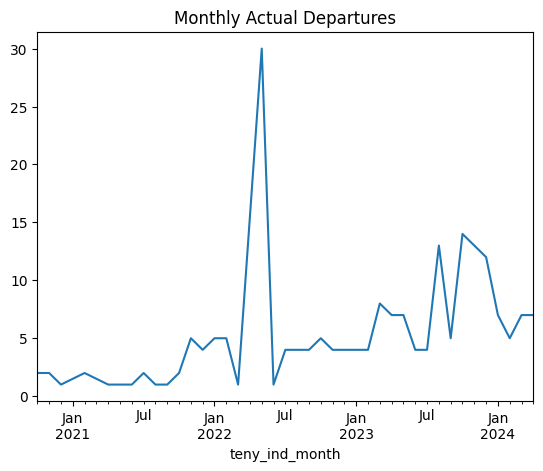

In [244]:
#Idősor elemzés
data_analysis['teny_ind_month'] = data_analysis['teny_ind'].dt.to_period('M')
monthly_departures = data_analysis.groupby('teny_ind_month').size()
monthly_departures.plot(kind='line', title='Monthly Actual Departures')

In [245]:
# Összehasonlító elemzés: terv vs teny
data_analysis['departure_delay'] = abs((data_analysis['teny_ind'] - data_analysis['terv_ind']).dt.total_seconds() / 60)  # in minutes
print(data_analysis['departure_delay'].describe())

count       200.000000
mean      20985.365000
std       59204.724243
min           0.000000
25%          59.750000
50%         137.000000
75%         541.000000
max      282292.000000
Name: departure_delay, dtype: float64


In [246]:
data_analysis[data_analysis["departure_delay"] > 50000]

,terv_ind,terv_erk,ind_nev_terv,erk__terv,teny_ind,teny_erk,rakom_tom,vonathossz,vontat_mode,vonatnem,ind_teny,erk_teny,terv_ind_Year,terv_ind_Month,terv_ind_Day,terv_ind_Hour,terv_ind_Minute,terv_ind_Second,terv_ind_WeekOfYear,terv_erk_Year,terv_erk_Month,terv_erk_Day,terv_erk_Hour,terv_erk_Minute,terv_erk_Second,terv_erk_WeekOfYear,teny_ind_Year,teny_ind_Month,teny_ind_Day,teny_ind_Hour,teny_ind_Minute,teny_ind_Second,teny_ind_WeekOfYear,teny_erk_Year,teny_erk_Month,teny_erk_Day,teny_erk_Hour,teny_erk_Minute,teny_erk_Second,teny_erk_WeekOfYear,travel_time_terv,travel_time_teny,teny_ind_month,departure_delay
110,2022-06-26 22:30:00,2022-06-26 22:49:00,Ferencv.Nyugati.r.,Soroksári út rendező,2022-05-22 21:38:00,2022-05-22 22:14:00,564760,172,tmDiesel,T,Ferencv.Nyugati.r.,Soroksári út rendező,2022,6,26,22,30,0,25,2022,6,26,22,49,0,25,2022,5,22,21,38,0,20,2022,5,22,22,14,0,20,19,36,2022-05,50452.0
111,2022-07-03 22:30:00,2022-03-07 22:49:00,Ferencv.Nyugati.r.,Soroksári út rendező,2022-05-22 21:38:00,2022-05-22 22:14:00,564760,172,tmDiesel,T,Ferencv.Nyugati.r.,Soroksári út rendező,2022,7,3,22,30,0,26,2022,7,3,22,49,0,26,2022,5,22,21,38,0,20,2022,5,22,22,14,0,20,19,36,2022-05,60532.0
112,2022-07-10 22:30:00,2022-10-07 22:49:00,Ferencv.Nyugati.r.,Soroksári út rendező,2022-05-22 21:38:00,2022-05-22 22:14:00,564760,172,tmDiesel,T,Ferencv.Nyugati.r.,Soroksári út rendező,2022,7,10,22,30,0,27,2022,7,10,22,49,0,27,2022,5,22,21,38,0,20,2022,5,22,22,14,0,20,19,36,2022-05,70612.0
113,2022-07-17 22:30:00,2022-07-17 22:49:00,Ferencv.Nyugati.r.,Soroksári út rendező,2022-05-22 21:38:00,2022-05-22 22:14:00,564760,172,tmDiesel,T,Ferencv.Nyugati.r.,Soroksári út rendező,2022,7,17,22,30,0,28,2022,7,17,22,49,0,28,2022,5,22,21,38,0,20,2022,5,22,22,14,0,20,19,36,2022-05,80692.0
114,2022-07-24 22:30:00,2022-07-24 22:49:00,Ferencv.Nyugati.r.,Soroksári út rendező,2022-05-22 21:38:00,2022-05-22 22:14:00,564760,172,tmDiesel,T,Ferencv.Nyugati.r.,Soroksári út rendező,2022,7,24,22,30,0,29,2022,7,24,22,49,0,29,2022,5,22,21,38,0,20,2022,5,22,22,14,0,20,19,36,2022-05,90772.0
115,2022-07-31 22:30:00,2022-07-31 22:49:00,Ferencv.Nyugati.r.,Soroksári út rendező,2022-05-22 21:38:00,2022-05-22 22:14:00,564760,172,tmDiesel,T,Ferencv.Nyugati.r.,Soroksári út rendező,2022,7,31,22,30,0,30,2022,7,31,22,49,0,30,2022,5,22,21,38,0,20,2022,5,22,22,14,0,20,19,36,2022-05,100852.0
116,2022-08-07 22:30:00,2022-07-08 22:49:00,Ferencv.Nyugati.r.,Soroksári út rendező,2022-05-22 21:38:00,2022-05-22 22:14:00,564760,172,tmDiesel,T,Ferencv.Nyugati.r.,Soroksári út rendező,2022,8,7,22,30,0,31,2022,8,7,22,49,0,31,2022,5,22,21,38,0,20,2022,5,22,22,14,0,20,19,36,2022-05,110932.0
117,2022-08-14 22:30:00,2022-08-14 22:49:00,Ferencv.Nyugati.r.,Soroksári út rendező,2022-05-22 21:38:00,2022-05-22 22:14:00,564760,172,tmDiesel,T,Ferencv.Nyugati.r.,Soroksári út rendező,2022,8,14,22,30,0,32,2022,8,14,22,49,0,32,2022,5,22,21,38,0,20,2022,5,22,22,14,0,20,19,36,2022-05,121012.0
118,2022-08-21 22:30:00,2022-08-21 22:49:00,Ferencv.Nyugati.r.,Soroksári út rendező,2022-05-22 21:38:00,2022-05-22 22:14:00,564760,172,tmDiesel,T,Ferencv.Nyugati.r.,Soroksári út rendező,2022,8,21,22,30,0,33,2022,8,21,22,49,0,33,2022,5,22,21,38,0,20,2022,5,22,22,14,0,20,19,36,2022-05,131092.0
119,2022-08-28 22:30:00,2022-08-28 22:49:00,Ferencv.Nyugati.r.,Soroksári út rendező,2022-05-22 21:38:00,2022-05-22 22:14:00,564760,172,tmDiesel,T,Ferencv.Nyugati.r.,Soroksári út rendező,2022,8,28,22,30,0,34,2022,8,28,22,49,0,34,2022,5,22,21,38,0,20,2022,5,22,22,14,0,20,19,36,2022-05,141172.0


In [247]:
# Compare scheduled and actual travel times
data_analysis['travel_time_difference'] = abs(data_analysis['travel_time_teny'] - data_analysis['travel_time_terv'])
print(data_analysis['travel_time_difference'].describe())

count     200.000000
mean      404.575000
std       461.055719
min         2.000000
25%        30.750000
50%       143.000000
75%       687.250000
max      1421.000000
Name: travel_time_difference, dtype: float64


In [248]:
# Correlation matrix for certain variables
correlation_matrix = data_analysis[['rakom_tom', 'vonathossz', 'travel_time_terv','travel_time_teny']].corr()
print(correlation_matrix)

                  rakom_tom  vonathossz  travel_time_terv  travel_time_teny
rakom_tom          1.000000    0.516777          0.017875         -0.058879
vonathossz         0.516777    1.000000          0.171116         -0.043113
travel_time_terv   0.017875    0.171116          1.000000          0.357295
travel_time_teny  -0.058879   -0.043113          0.357295          1.000000


In [249]:
# Analysis of train types and their frequencies
train_type_distribution = data_analysis['vonatnem'].value_counts()
print(train_type_distribution)

vonatnem
T     102
M      97
Gt      1
Name: count, dtype: int64


In [250]:
# Average actual travel time by train type
average_travel_time_by_type = data_analysis.groupby('vonatnem')['travel_time_teny'].mean()
print(average_travel_time_by_type)

vonatnem
Gt    813.000000
M     587.597938
T     399.460784
Name: travel_time_teny, dtype: float64


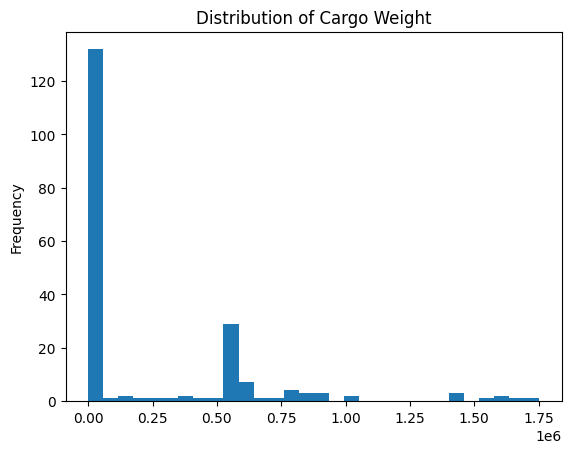

In [251]:
# Histogram for 'rakom_tom'
data_analysis['rakom_tom'].plot(kind='hist', bins=30, title='Distribution of Cargo Weight')
plt.show()

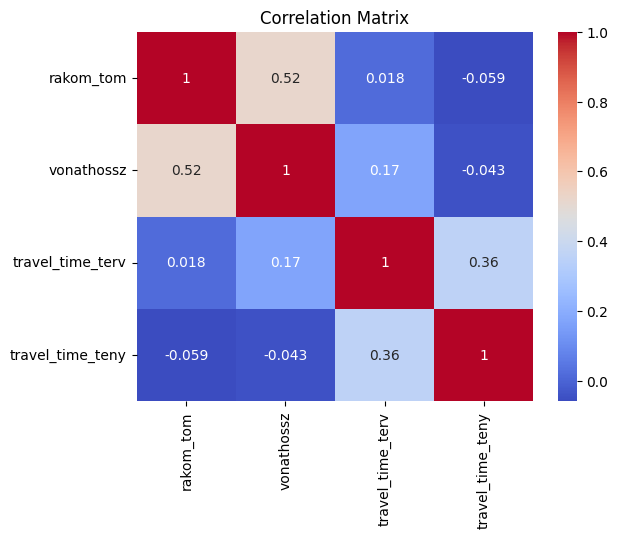

In [252]:
# Heat map for correlations
import seaborn as sns

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Normalizálás

In [253]:
dataset.drop('terv_ind', axis=1, inplace=True)
dataset.drop('terv_erk', axis=1, inplace=True)
dataset.drop('teny_ind', axis=1, inplace=True)
dataset.drop('teny_erk', axis=1, inplace=True)

In [254]:
scaler = MinMaxScaler().fit(inputs[numeric_cols])
inputs[numeric_cols] = scaler.transform(inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

OneHotEncoding


In [255]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(inputs[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
inputs[encoded_cols] = encoder.transform(inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-255-a4fce10cc6af>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inputs[encoded_cols] = encoder.transform(inputs[categorical_cols])
<ipython-input-255-a4fce10cc6af>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inputs[encoded_cols] = encoder.tr

In [256]:
X = inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

In [257]:
model = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=50, max_depth=4)

In [258]:
%%time
model.fit(X, targets)

CPU times: user 322 ms, sys: 4.74 ms, total: 327 ms
Wall time: 218 ms


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [259]:
preds = model.predict(X)

In [260]:
def mse(a, b):
  return mean_squared_error(a, b, squared=True)

In [261]:
def mae(a, b):
  return mean_absolute_error(a,b)

In [262]:
xgbRegressorTrainMSE = mse(preds, targets)
xgbRegressorTrainMAE = mae(preds, targets)


print("mse (train): ",mse(preds, targets))
print("mae (train): ",mae(preds, targets))

preds_test = model.predict(X_test)

xgbRegressorTestMSE = mse(preds_test, y_test)
xgbRegressorTestMAE = mae(preds_test, y_test)

print("mse (train): ",mse(preds_test, y_test))
print("mae (train): ",mae(preds_test, y_test))

mse (train):  1168.4421161571845
mae (train):  24.893870326450894
mse (train):  161078.73853746953
mae (train):  264.88161481221516


In [263]:
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)
importance_df.head()

,feature,importance
194,erk_teny_Soroksári út rendező,0.271386
30,travel_time_terv,0.069608
166,erk_teny_Gyékényes,0.062272
151,erk_teny_Almásfüzitő,0.055967
79,ind_nev_terv_Szolnok-Rendező,0.054141


In [264]:
X = inputs[importance_df[importance_df.importance > 0.001].feature].copy()
X_test = test_inputs[importance_df[importance_df.importance > 0.001].feature].copy()

In [265]:
model = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=50, max_depth=4)

In [266]:
%%time
model.fit(X, targets)

CPU times: user 130 ms, sys: 1.86 ms, total: 132 ms
Wall time: 90 ms


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [267]:
preds = model.predict(X)

In [268]:
xgbRegressorImportantTrainMSE = mse(preds, targets)
xgbRegressorImportantTrainMAE = mae(preds, targets)

print("mse: ",mse(preds, targets))
print("mae: ",mae(preds, targets))

mse:  942.8305019878117
mae:  22.114049516405377


In [269]:
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)
importance_df.head()

,feature,importance
0,erk_teny_Soroksári út rendező,0.335872
3,erk_teny_Almásfüzitő,0.069266
5,ind_nev_terv_Tatabánya,0.056204
9,terv_ind_Year,0.042081
6,ind_nev_terv_Karcag,0.038305


In [270]:
def train_and_evaluateMSE(X_train, train_targets, X_val, val_targets, **params):
    model = XGBRegressor(random_state=42, n_jobs=-1, **params)
    model.fit(X_train, train_targets)
    train_mse = mse(model.predict(X_train), train_targets)
    val_mse = mse(model.predict(X_val), val_targets)
    train_mae = mae(model.predict(X_train), train_targets)
    val_mae = mae(model.predict(X_val), val_targets)
    return model, train_mse, val_mse

In [271]:
def train_and_evaluateMAE(X_train, train_targets, X_val, val_targets, **params):
    model = XGBRegressor(random_state=42, n_jobs=-1, **params)
    model.fit(X_train, train_targets)
    train_mse = mse(model.predict(X_train), train_targets)
    val_mse = mse(model.predict(X_val), val_targets)
    train_mae = mae(model.predict(X_train), train_targets)
    val_mae = mae(model.predict(X_val), val_targets)
    return model, train_mae, val_mae

In [272]:
kfold = KFold(n_splits=5)

In [273]:
models = []

for train_idxs, val_idxs in kfold.split(X):
    X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
    X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
    model, train_mse, val_mse = train_and_evaluateMSE(X_train,
                                                     train_targets,
                                                     X_val,
                                                     val_targets,
                                                     max_depth=4,
                                                     n_estimators=20)
    models.append(model)
    print('Train MSE: {}, Validation MSE: {}'.format(train_mse, val_mse))

Train MSE: 4101.744731288953, Validation MSE: 122855.25964606626
Train MSE: 4437.924212653011, Validation MSE: 210486.84102744467
Train MSE: 7107.6250269877655, Validation MSE: 273348.7050146272
Train MSE: 5466.368475802878, Validation MSE: 193460.74544590476
Train MSE: 4188.819472543702, Validation MSE: 403640.94713839557


In [274]:
models = []

for train_idxs, val_idxs in kfold.split(X):
    X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
    X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
    model, train_mae, val_mae = train_and_evaluateMAE(X_train,
                                                     train_targets,
                                                     X_val,
                                                     val_targets,
                                                     max_depth=4,
                                                     n_estimators=20)
    models.append(model)
    print('Train MSE: {}, Validation MAE: {}'.format(train_mae, val_mae))

Train MSE: 48.132277488708496, Validation MAE: 261.82445430755615
Train MSE: 48.140545640672954, Validation MAE: 323.8258992603847
Train MSE: 61.4836368901389, Validation MAE: 409.3946461677551
Train MSE: 54.58061909675598, Validation MAE: 337.43579632895336
Train MSE: 44.74959060123989, Validation MAE: 431.6646990094866


In [275]:
def predict_avg(models, inputs):
    return np.mean([model.predict(inputs) for model in models], axis=0)

In [276]:
preds = predict_avg(models, X_train)
preds

array([1032.7377  ,   36.35438 ,  449.07236 , 1233.8861  ,   38.742657,
       1073.0953  ,  196.38618 ,  184.05406 ,  262.4393  , 1037.3817  ,
        899.4334  ,  102.11886 ,  230.58968 ,   47.887817, 1082.5591  ,
         85.112274,  711.50885 ,  217.76115 ,  220.7701  ,  333.80536 ,
        771.59045 ,  211.53256 ,  290.86996 ,   96.18498 ,   38.742657,
        491.52237 ,   42.45911 , 1078.604   ,   47.887817, 1020.16095 ,
         36.35438 , 1225.7599  ,  151.97987 , 1112.6104  ,  177.11533 ,
        242.11905 ,  391.58032 ,  490.07217 ,  939.69794 ,   42.45911 ,
         36.35438 ,  678.52997 , 1114.7128  ,   38.742657,  102.11886 ,
        439.16913 ,  331.26862 ,  208.983   , 1118.5618  ,   42.45911 ,
         38.742657,   88.166504,  837.0338  ,  440.34406 ,  795.38367 ,
       1029.8428  ,  273.73627 ,  294.05768 ,  232.41928 ,  120.89158 ,
        275.702   ,  108.242935, 1094.6831  , 1056.6042  ,  808.7213  ,
        965.9479  ,  857.53534 , 1177.7849  , 1136.883   , 1060.

In [277]:
drop_col = ["ind_nev_terv", "vontat_mode", "vonatnem", "ind_teny", "erk_teny"]
inputs.drop(drop_col, axis = 1, inplace = True)
test_inputs.drop(drop_col, axis = 1, inplace = True)


In [278]:
from sklearn.model_selection import RandomizedSearchCV


# ## Hyper Parameter Optimization
# n_estimators = [50, 75, 100, 200]
# max_depth = [2, 3, 5, 10, 15]
# learning_rate=[0.05,0.1,0.15,0.2]
# min_child_weight=[1,2,3,4]

# # Define the grid of hyperparameters to search
# hyperparameter_grid = {
#     'n_estimators': n_estimators,
#     'max_depth':max_depth,
#     'learning_rate':learning_rate,
#     'min_child_weight':min_child_weight
#     }

# # Set up the random search with 4-fold cross validation
# random_cv = RandomizedSearchCV(estimator=model,
#             param_distributions=hyperparameter_grid,
#             cv=5, n_iter=50,
#             scoring = 'neg_mean_absolute_error',n_jobs = 5,
#             verbose = 5,
#             return_train_score = True,
#             random_state=42)

# random_cv.fit(inputs,targets)

# print(random_cv.best_estimator_)

In [279]:
def train_and_evaluateMSE(X_train, train_targets, X_val, val_targets, **params):
    model = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=-1, importance_type='gain', interaction_constraints=None,
             learning_rate=0.15, max_delta_step=None, max_depth=10,
             min_child_weight=1, monotone_constraints=None,
             n_estimators=200, n_jobs=-1, num_parallel_tree=None,
             random_state=42, reg_alpha=0, reg_lambda=0, scale_pos_weight=1,
             subsample=None, tree_method=None, validate_parameters=1,
             verbosity=None)

    model.fit(X_train, train_targets)
    train_mse = mse(model.predict(X_train), train_targets)
    val_mse = mse(model.predict(X_val), val_targets)

    return model, train_mse, val_mse

In [280]:
def train_and_evaluateMAE(X_train, train_targets, X_val, val_targets, **params):
    model = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=-1, importance_type='gain', interaction_constraints=None,
             learning_rate=0.15, max_delta_step=None, max_depth=10,
             min_child_weight=1, monotone_constraints=None,
             n_estimators=200, n_jobs=-1, num_parallel_tree=None,
             random_state=42, reg_alpha=0, reg_lambda=0, scale_pos_weight=1,
             subsample=None, tree_method=None, validate_parameters=1,
             verbosity=None)
    model.fit(X_train, train_targets)

    train_mae = mae(model.predict(X_train), train_targets)
    val_mae = mae(model.predict(X_val), val_targets)

    return model, train_mae, val_mae

In [281]:
kfold = KFold(n_splits=5)
models = []

for train_idxs, val_idxs in kfold.split(X):
    X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
    X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
    model, train_mse, val_mse = train_and_evaluateMSE(X_train,
                                                     train_targets,
                                                     X_val,
                                                     val_targets,
                                                     max_depth=4,
                                                     n_estimators=20)
    models.append(model)
    print('Train MSE: {}, Validation MSE: {}'.format(train_mse, val_mse))

Train MSE: 1.6098783817142248e-07, Validation MSE: 193266.2234744076
Train MSE: 1.7640471534312902e-07, Validation MSE: 377826.4363974031
Train MSE: 1.652719480002166e-07, Validation MSE: 590184.7336639836
Train MSE: 1.794188538692002e-07, Validation MSE: 274835.5228758274
Train MSE: 1.902693855169803e-07, Validation MSE: 601970.8830903784


In [282]:
models = []

for train_idxs, val_idxs in kfold.split(X):
    X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
    X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
    model, train_mae, val_mae = train_and_evaluateMAE(X_train,
                                                     train_targets,
                                                     X_val,
                                                     val_targets,
                                                     max_depth=4,
                                                     n_estimators=20)
    models.append(model)
    print('Train MSE: {}, Validation MAE: {}'.format(train_mae, val_mae))

Train MSE: 0.00032390866960797993, Validation MAE: 258.8979778289795
Train MSE: 0.0003340073994227818, Validation MAE: 418.28718703133717
Train MSE: 0.00032891545976911275, Validation MAE: 580.603178705488
Train MSE: 0.00033219371523175923, Validation MAE: 309.8859615325928
Train MSE: 0.0003649592399597168, Validation MAE: 554.7588146754673


In [283]:
regressor = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=-1, importance_type='gain', interaction_constraints=None,
             learning_rate=0.15, max_delta_step=None, max_depth=10,
             min_child_weight=1, monotone_constraints=None,
             n_estimators=200, n_jobs=-1, num_parallel_tree=None,
             random_state=42, reg_alpha=0, reg_lambda=0, scale_pos_weight=1,
             subsample=None, tree_method=None, validate_parameters=1,
             verbosity=None)

regressor.fit(inputs,targets)
y_pred = regressor.predict(test_inputs)

In [284]:
test_pred = regressor.predict(test_inputs)

xgbRegressorGsHptTestMSE = mse(test_pred, y_test)
xgbRegressorGsHptTestMAE =  mae(test_pred, y_test)

print("mse: ",mse(test_pred, y_test))
print("mae: ",mae(test_pred, y_test))

mse:  312571.0148250304
mae:  370.20998058319094


In [285]:
train_pred = regressor.predict(inputs)

xgbRegressorGsHptTrainMSE = mse(train_pred, targets)
xgbRegressorGsHptTrainMAE =  mae(train_pred, targets)

print("mse: ",mse(train_pred, targets))
print("mae: ",mae(train_pred, targets))

mse:  1.7583497537998483e-07
mae:  0.0003371783665248326


In [286]:
test_targets_xgb = y_test
test_targets_xgb["test_pred"] = test_pred

#4377
idx = dataset_min_change.index.intersection(test_inputs.index)
print(idx)
dataset_min_changeXGB = dataset_min_change.loc[idx]
dataset_min_changeXGB["y_test"] = test_targets_xgb["travel_time_teny"]
dataset_min_changeXGB["predicted_travel_time"] = test_targets_xgb["test_pred"]
dataset_min_changeXGB.to_csv('submissionXGB.csv', index=None)

Index([  1,   8,  10,  14,  17,  18,  23,  25,  27,  32,  34,  38,  44,  45,
        56,  59,  60,  62,  72,  74,  75,  78,  80,  83,  84,  87,  88,  89,
        90,  93,  95,  96,  97, 103, 104, 107, 109, 113, 116, 122, 123, 124,
       126, 128, 134, 139, 141, 147, 153, 155, 157, 164, 167, 172, 173, 180,
       181, 182, 184, 191],
      dtype='int64')


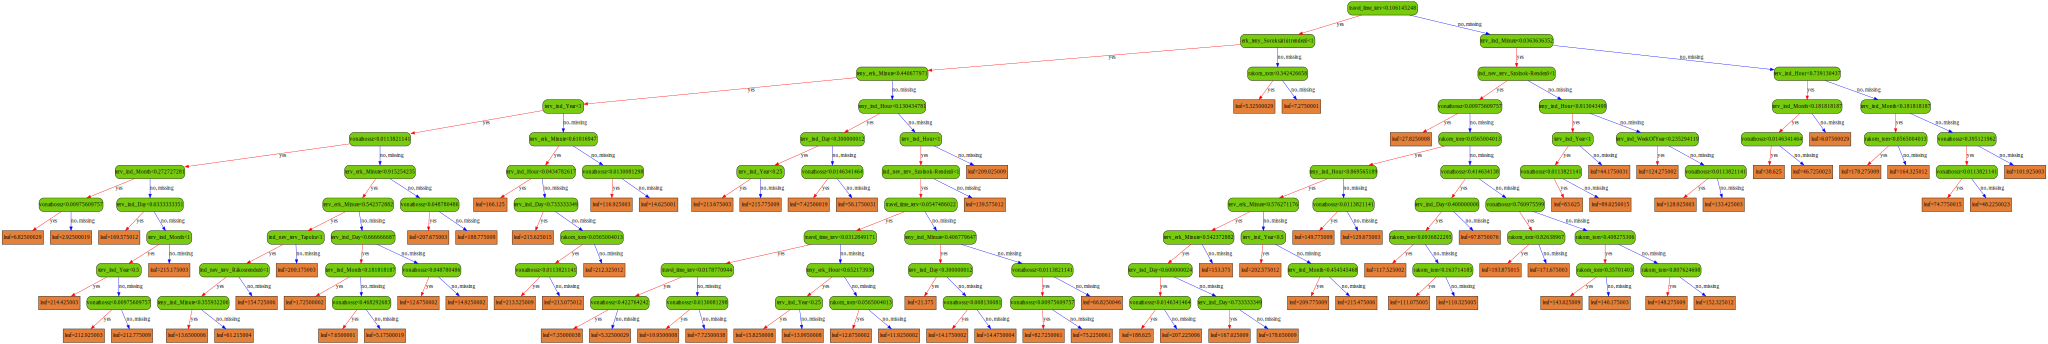

In [287]:
node_params = {
    'shape':'box',
    'style':'filled, rounded',
    'fillcolor':'#78cbe'
}
leaf_params = {
    'shape':'box',
    'style':'filled',
    'fillcolor':'#e48038'
}
image = xgb.to_graphviz(regressor, num_trees=0,size="1,1", condition_node_params=node_params, leaf_node_params=leaf_params)
image.graph_attr = {'dpi':'400'}
image.render('xgb_individualtree', format = 'png')
image

In [288]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn import metrics

y_test.drop('test_pred', axis = 1, inplace = True)

model = RandomForestRegressor(random_state=1)
model.fit(inputs, targets)
predicted_values = model.predict(test_inputs)
predicted_valuesTrain = model.predict(inputs)

randomForestRegressorTrainMSE = metrics.mean_squared_error(targets, predicted_valuesTrain)
randomForestRegressorTrainMAE = metrics.mean_absolute_error(targets, predicted_valuesTrain)
randomForestRegressorTestMSE = metrics.mean_squared_error(y_test, predicted_values)
randomForestRegressorTestMAE = metrics.mean_absolute_error(y_test, predicted_values)

print("mean squared error (train): ",metrics.mean_squared_error(targets, predicted_valuesTrain))
print("mean squared error (test): ",metrics.mean_squared_error(y_test, predicted_values))
print("mean absolute error (train): ",metrics.mean_absolute_error(targets, predicted_valuesTrain))
print("mean absolute error (test): ",metrics.mean_absolute_error(y_test, predicted_values))

<ipython-input-288-8733fe88dc6c>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(inputs, targets)


mean squared error (train):  30066.601533571433
mean squared error (test):  129741.77024666667
mean absolute error (train):  125.05521428571429
mean absolute error (test):  248.45066666666668


In [289]:
predicted_values

array([ 688.24,  299.29,  581.54,  311.63,  987.12,   36.  ,  974.62,
        384.2 ,  270.8 ,  434.55,  907.95,   36.  ,  289.17,  133.55,
         36.  ,  633.65,  697.88,  810.08,  369.53,   36.  ,  283.03,
        273.72,   36.  ,  813.12,  304.  ,  509.46,  295.59,  710.8 ,
        319.05,  412.47,  551.06,  275.21,   36.  ,  810.05,  334.71,
        444.65,  780.44,   36.  ,   39.48,  317.66,  380.18,  114.14,
        600.65,  725.61,  378.92, 1081.56,  977.  ,  341.5 ,  448.83,
        397.23,  325.37,  668.45,  708.12,  580.  , 1000.71,  432.21,
        526.46,  949.56,   36.  ,  870.92])

In [290]:
test_targets = y_test
test_targets["predicted_values"] = predicted_values
test_targets

,travel_time_teny,predicted_values
90,1320,688.24
80,425,299.29
87,483,581.54
59,384,311.63
72,1438,987.12
126,36,36.00
89,1102,974.62
191,47,384.20
88,456,270.80
139,96,434.55


In [291]:
dataset_min_change

,terv_ind,terv_erk,ind_nev_terv,erk__terv,teny_ind,teny_erk,rakom_tom,vonathossz,vontat_mode,vonatnem,ind_teny,erk_teny,terv_ind_Year,terv_ind_Month,terv_ind_Day,terv_ind_Hour,terv_ind_Minute,terv_ind_Second,terv_ind_WeekOfYear,terv_erk_Year,terv_erk_Month,terv_erk_Day,terv_erk_Hour,terv_erk_Minute,terv_erk_Second,terv_erk_WeekOfYear,teny_ind_Year,teny_ind_Month,teny_ind_Day,teny_ind_Hour,teny_ind_Minute,teny_ind_Second,teny_ind_WeekOfYear,teny_erk_Year,teny_erk_Month,teny_erk_Day,teny_erk_Hour,teny_erk_Minute,teny_erk_Second,teny_erk_WeekOfYear
0,2021-04-11 11:00:00,2021-04-11 11:09:00,Szajol,Szolnok,2021-04-11 13:10:00,2021-04-11 13:00:00,0,18,NaN,M,Szajol,Szolnok,2021,4,11,11,0,0,14,2021,4,11,11,9,0,14,2021,4,11,13,10,0,14,2021,4,11,13,0,0,14
1,2021-09-21 18:00:00,2021-09-21 18:52:00,Rákos,Bicske,2021-09-21 19:41:00,2021-09-22 02:20:00,0,270,NaN,T,Rákos,Bicske,2021,9,21,18,0,0,38,2021,9,21,18,52,0,38,2021,9,21,19,41,0,38,2021,9,22,2,20,0,38
2,2021-07-23 23:00:00,2021-07-23 23:16:00,Karcag,Püspökladány,2021-07-23 22:21:00,2021-07-23 21:35:00,480000,258,NaN,T,Karcag,Püspökladány,2021,7,23,23,0,0,29,2021,7,23,23,16,0,29,2021,7,23,22,21,0,29,2021,7,23,21,35,0,29
3,2021-12-19 10:00:00,2021-12-19 16:14:00,Cegléd,Kisújszállás,2021-12-19 21:14:00,2021-12-20 13:08:00,600000,480,tmDiesel,T,Cegléd,Kisújszállás,2021,12,19,10,0,0,50,2021,12,19,16,14,0,50,2021,12,19,21,14,0,50,2021,12,20,13,8,0,51
4,2022-01-30 17:30:00,2022-01-30 21:26:00,Szabadbattyán,Uzsabánya,2022-01-30 16:16:00,2022-01-31 12:05:00,0,300,tmDiesel,T,Szabadbattyán,Uzsabánya,2022,1,30,17,30,0,4,2022,1,30,21,26,0,4,2022,1,30,16,16,0,4,2022,1,31,12,5,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2023-06-29 11:00:00,2023-06-29 11:30:00,Szerencs,Tállya,2023-06-29 09:20:00,2023-06-29 10:14:00,0,411,NaN,T,Szerencs,Tállya,2023,6,29,11,0,0,26,2023,6,29,11,30,0,26,2023,6,29,9,20,0,26,2023,6,29,10,14,0,26
196,2023-07-15 16:17:00,2023-07-15 16:57:00,Kiskunfélegyháza,Kiskunhalas,2023-07-15 20:07:00,2023-07-15 21:32:00,0,18,NaN,M,Kiskunfélegyháza,Kiskunhalas,2023,7,15,16,17,0,28,2023,7,15,16,57,0,28,2023,7,15,20,7,0,28,2023,7,15,21,32,0,28
197,2023-12-15 01:00:00,2023-12-15 01:26:00,Ferencváros,Rákosrendező,2023-12-14 23:08:00,2023-12-15 00:21:00,0,458,tmElectric,T,Ferencváros,Rákosrendező,2023,12,15,1,0,0,50,2023,12,15,1,26,0,50,2023,12,14,23,8,0,50,2023,12,15,0,21,0,50
198,2024-02-13 16:00:00,2024-02-13 16:55:00,Felsőzsolca,Füzesabony,2024-02-13 15:41:00,2024-02-13 17:19:00,0,20,tmElectric,M,Felsőzsolca,Füzesabony,2024,2,13,16,0,0,7,2024,2,13,16,55,0,7,2024,2,13,15,41,0,7,2024,2,13,17,19,0,7


In [292]:
#4525
idx = dataset_min_change.index.intersection(test_inputs.index)
print(idx)

Index([  1,   8,  10,  14,  17,  18,  23,  25,  27,  32,  34,  38,  44,  45,
        56,  59,  60,  62,  72,  74,  75,  78,  80,  83,  84,  87,  88,  89,
        90,  93,  95,  96,  97, 103, 104, 107, 109, 113, 116, 122, 123, 124,
       126, 128, 134, 139, 141, 147, 153, 155, 157, 164, 167, 172, 173, 180,
       181, 182, 184, 191],
      dtype='int64')


In [293]:
dataset_min_change = dataset_min_change.loc[idx]

In [294]:
dataset_min_change["y_test"] = test_targets["travel_time_teny"]
dataset_min_change["predicted_travel_time"] = test_targets["predicted_values"]

In [295]:
dataset_min_change

,terv_ind,terv_erk,ind_nev_terv,erk__terv,teny_ind,teny_erk,rakom_tom,vonathossz,vontat_mode,vonatnem,ind_teny,erk_teny,terv_ind_Year,terv_ind_Month,terv_ind_Day,terv_ind_Hour,terv_ind_Minute,terv_ind_Second,terv_ind_WeekOfYear,terv_erk_Year,terv_erk_Month,terv_erk_Day,terv_erk_Hour,terv_erk_Minute,terv_erk_Second,terv_erk_WeekOfYear,teny_ind_Year,teny_ind_Month,teny_ind_Day,teny_ind_Hour,teny_ind_Minute,teny_ind_Second,teny_ind_WeekOfYear,teny_erk_Year,teny_erk_Month,teny_erk_Day,teny_erk_Hour,teny_erk_Minute,teny_erk_Second,teny_erk_WeekOfYear,y_test,predicted_travel_time
1,2021-09-21 18:00:00,2021-09-21 18:52:00,Rákos,Bicske,2021-09-21 19:41:00,2021-09-22 02:20:00,0,270,NaN,T,Rákos,Bicske,2021,9,21,18,0,0,38,2021,9,21,18,52,0,38,2021,9,21,19,41,0,38,2021,9,22,2,20,0,38,399,275.21
8,2023-09-08 14:00:00,2023-09-08 15:12:00,Rajka,Tarjánpuszta,2023-09-08 14:25:00,2023-09-08 21:11:00,0,17,tmDiesel,M,Rajka,Tarjánpuszta,2023,9,8,14,0,0,36,2023,9,8,15,12,0,36,2023,9,8,14,25,0,36,2023,9,8,21,11,0,36,406,325.37
10,2023-11-23 20:53:00,2023-11-23 23:44:00,Tatabánya,Dunakeszi,2023-11-23 21:14:00,2023-11-24 17:56:00,1584060,407,tmDieselVillany,T,Tatabánya,Dunakeszi,2023,11,23,20,53,0,47,2023,11,23,23,44,0,47,2023,11,23,21,14,0,47,2023,11,24,17,56,0,47,1242,697.88
14,2023-05-31 16:00:00,2023-05-31 22:13:00,Nagykanizsa,Hidasnémeti,2023-05-31 18:00:00,2023-06-01 09:30:00,0,20,NaN,M,Nagykanizsa,Hidasnémeti,2023,5,31,16,0,0,22,2023,5,31,22,13,0,22,2023,5,31,18,0,0,22,2023,6,1,9,30,0,22,930,949.56
17,2023-10-01 08:00:00,2023-10-01 08:08:00,Budaörs,Biatorbágy,2023-10-01 09:29:00,2023-10-01 18:35:00,0,19,NaN,M,Budaörs,Biatorbágy,2023,10,1,8,0,0,39,2023,10,1,8,8,0,39,2023,10,1,9,29,0,39,2023,10,1,18,35,0,39,546,432.21
18,2023-12-05 12:00:00,2023-12-05 12:17:00,Hernádnémeti-Bőcs,Szerencs,2023-12-05 11:30:00,2023-12-05 17:30:00,0,20,NaN,M,Hernádnémeti-Bőcs,Szerencs,2023,12,5,12,0,0,49,2023,12,5,12,17,0,49,2023,12,5,11,30,0,49,2023,12,5,17,30,0,49,360,295.59
23,2024-03-20 10:00:00,2024-03-20 21:37:00,Baja,Rajka,2024-03-20 09:44:00,2024-03-21 02:29:00,0,200,tmDiesel,T,Baja,Rajka,2024,3,20,10,0,0,12,2024,3,20,21,37,0,12,2024,3,20,9,44,0,12,2024,3,21,2,29,0,12,1005,810.05
25,2024-04-11 08:50:00,2024-04-11 09:19:00,Ferencv.Nyugati.r.,Soroksár-Terminál,2024-04-11 08:29:00,2024-04-11 19:00:00,0,30,NaN,T,Ferencv.Nyugati.r.,Soroksár-Terminál,2024,4,11,8,50,0,15,2024,4,11,9,19,0,15,2024,4,11,8,29,0,15,2024,4,11,19,0,0,15,631,668.45
27,2021-02-18 14:00:00,2021-02-18 14:58:00,Szolnok-Rendező,Püspökladány,2021-02-18 11:20:00,2021-02-18 17:31:00,0,20,NaN,M,Szolnok-Rendező,Püspökladány,2021,2,18,14,0,0,7,2021,2,18,14,58,0,7,2021,2,18,11,20,0,7,2021,2,18,17,31,0,7,371,412.47
32,2022-02-22 23:50:00,2022-02-22 02:47:00,Kiskunfélegyháza,Békéscsaba,2022-02-23 02:10:00,2022-02-23 01:50:00,0,32,NaN,T,Kiskunfélegyháza,Békéscsaba,2022,2,22,23,50,0,8,2022,2,22,2,47,0,8,2022,2,23,2,10,0,8,2022,2,23,1,50,0,8,1420,708.12


In [296]:
dataset_min_change.columns

Index(['terv_ind', 'terv_erk', 'ind_nev_terv', 'erk__terv', 'teny_ind',
       'teny_erk', 'rakom_tom', 'vonathossz', 'vontat_mode', 'vonatnem',
       'ind_teny', 'erk_teny', 'terv_ind_Year', 'terv_ind_Month',
       'terv_ind_Day', 'terv_ind_Hour', 'terv_ind_Minute', 'terv_ind_Second',
       'terv_ind_WeekOfYear', 'terv_erk_Year', 'terv_erk_Month',
       'terv_erk_Day', 'terv_erk_Hour', 'terv_erk_Minute', 'terv_erk_Second',
       'terv_erk_WeekOfYear', 'teny_ind_Year', 'teny_ind_Month',
       'teny_ind_Day', 'teny_ind_Hour', 'teny_ind_Minute', 'teny_ind_Second',
       'teny_ind_WeekOfYear', 'teny_erk_Year', 'teny_erk_Month',
       'teny_erk_Day', 'teny_erk_Hour', 'teny_erk_Minute', 'teny_erk_Second',
       'teny_erk_WeekOfYear', 'y_test', 'predicted_travel_time'],
      dtype='object')

In [297]:
dataset_min_change.to_csv('submissionRFR.csv', index=None)

In [298]:
parameters = {
    'n_estimators': [50,100,150,200],
    'max_depth': [item for item in range(3, 15+1)]
}

In [299]:
#inputs = x_train
#targets = y_train
#test_inputs = x_test
from sklearn.model_selection import GridSearchCV
# clf = GridSearchCV(model, parameters)
# gs  = clf.fit(inputs, targets.values.ravel())
# print(gs.best_params_)

In [300]:
model = RandomForestRegressor(random_state=1, max_depth=15, n_estimators=200)
model.fit(inputs, targets)

<ipython-input-300-39e41942ea37>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(inputs, targets)


RandomForestRegressor(max_depth=15, n_estimators=200, random_state=1)

In [301]:
y_pred_train = model.predict(inputs)

randomForestRegressorGsHptTrainMSE = metrics.mean_squared_error(targets, y_pred_train)
randomForestRegressorGsHptTrainMAE = metrics.mean_absolute_error(targets, y_pred_train)

print("mse: ",metrics.mean_squared_error(targets, y_pred_train))
print("mae: ",metrics.mean_absolute_error(targets, y_pred_train))

mse:  29642.010822930726
mae:  124.31231366737597


In [302]:
y_test.drop('travel_time_teny', axis=1, inplace=True)
y_pred = model.predict(test_inputs)


randomForestRegressorGsHptTestMSE = metrics.mean_squared_error(y_test, y_pred)
randomForestRegressorGsHptTestMAE = metrics.mean_absolute_error(y_test, y_pred)

print("mse: ",metrics.mean_squared_error(y_test, y_pred))
print("mae: ",metrics.mean_absolute_error(y_test, y_pred))


mse:  991.8673044794182
mae:  24.481995872527776


In [303]:
print(y_test)

     predicted_values
90             688.24
80             299.29
87             581.54
59             311.63
72             987.12
126             36.00
89             974.62
191            384.20
88             270.80
139            434.55
182            907.95
122             36.00
97             289.17
93             133.55
116             36.00
172            633.65
10             697.88
147            810.08
96             369.53
107             36.00
134            283.03
44             273.72
123             36.00
83             813.12
75             304.00
103            509.46
18             295.59
56             710.80
155            319.05
27             412.47
184            551.06
1              275.21
109             36.00
23             810.05
173            334.71
153            444.65
104            780.44
124             36.00
128             39.48
60             317.66
38             380.18
157            114.14
167            600.65
95             725.61
141       

In [304]:
dataset[numeric_cols] = scaler.transform(dataset[numeric_cols])

encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(dataset[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
dataset[encoded_cols] = encoder.transform(dataset[categorical_cols])
X_test = dataset[numeric_cols + encoded_cols]
clf = model.fit(X_test, y)
all_pred = clf.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-304-432563adf575>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[encoded_cols] = encoder.transform(dataset[categorical_cols])
<ipython-input-304-432563adf575>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[encoded_cols] = encoder

In [305]:
randomForestTreeGsHptAllMSE =  metrics.mean_squared_error(y, all_pred)
randomForestTreeGsHptAllMAE =  metrics.mean_absolute_error(y, all_pred)
print("mse: ",metrics.mean_squared_error(y, all_pred))
print("mae: ",metrics.mean_absolute_error(y, all_pred))

mse:  27072.913551559657
mae:  117.66966702769503


Összegezve: modellek teljesítménye

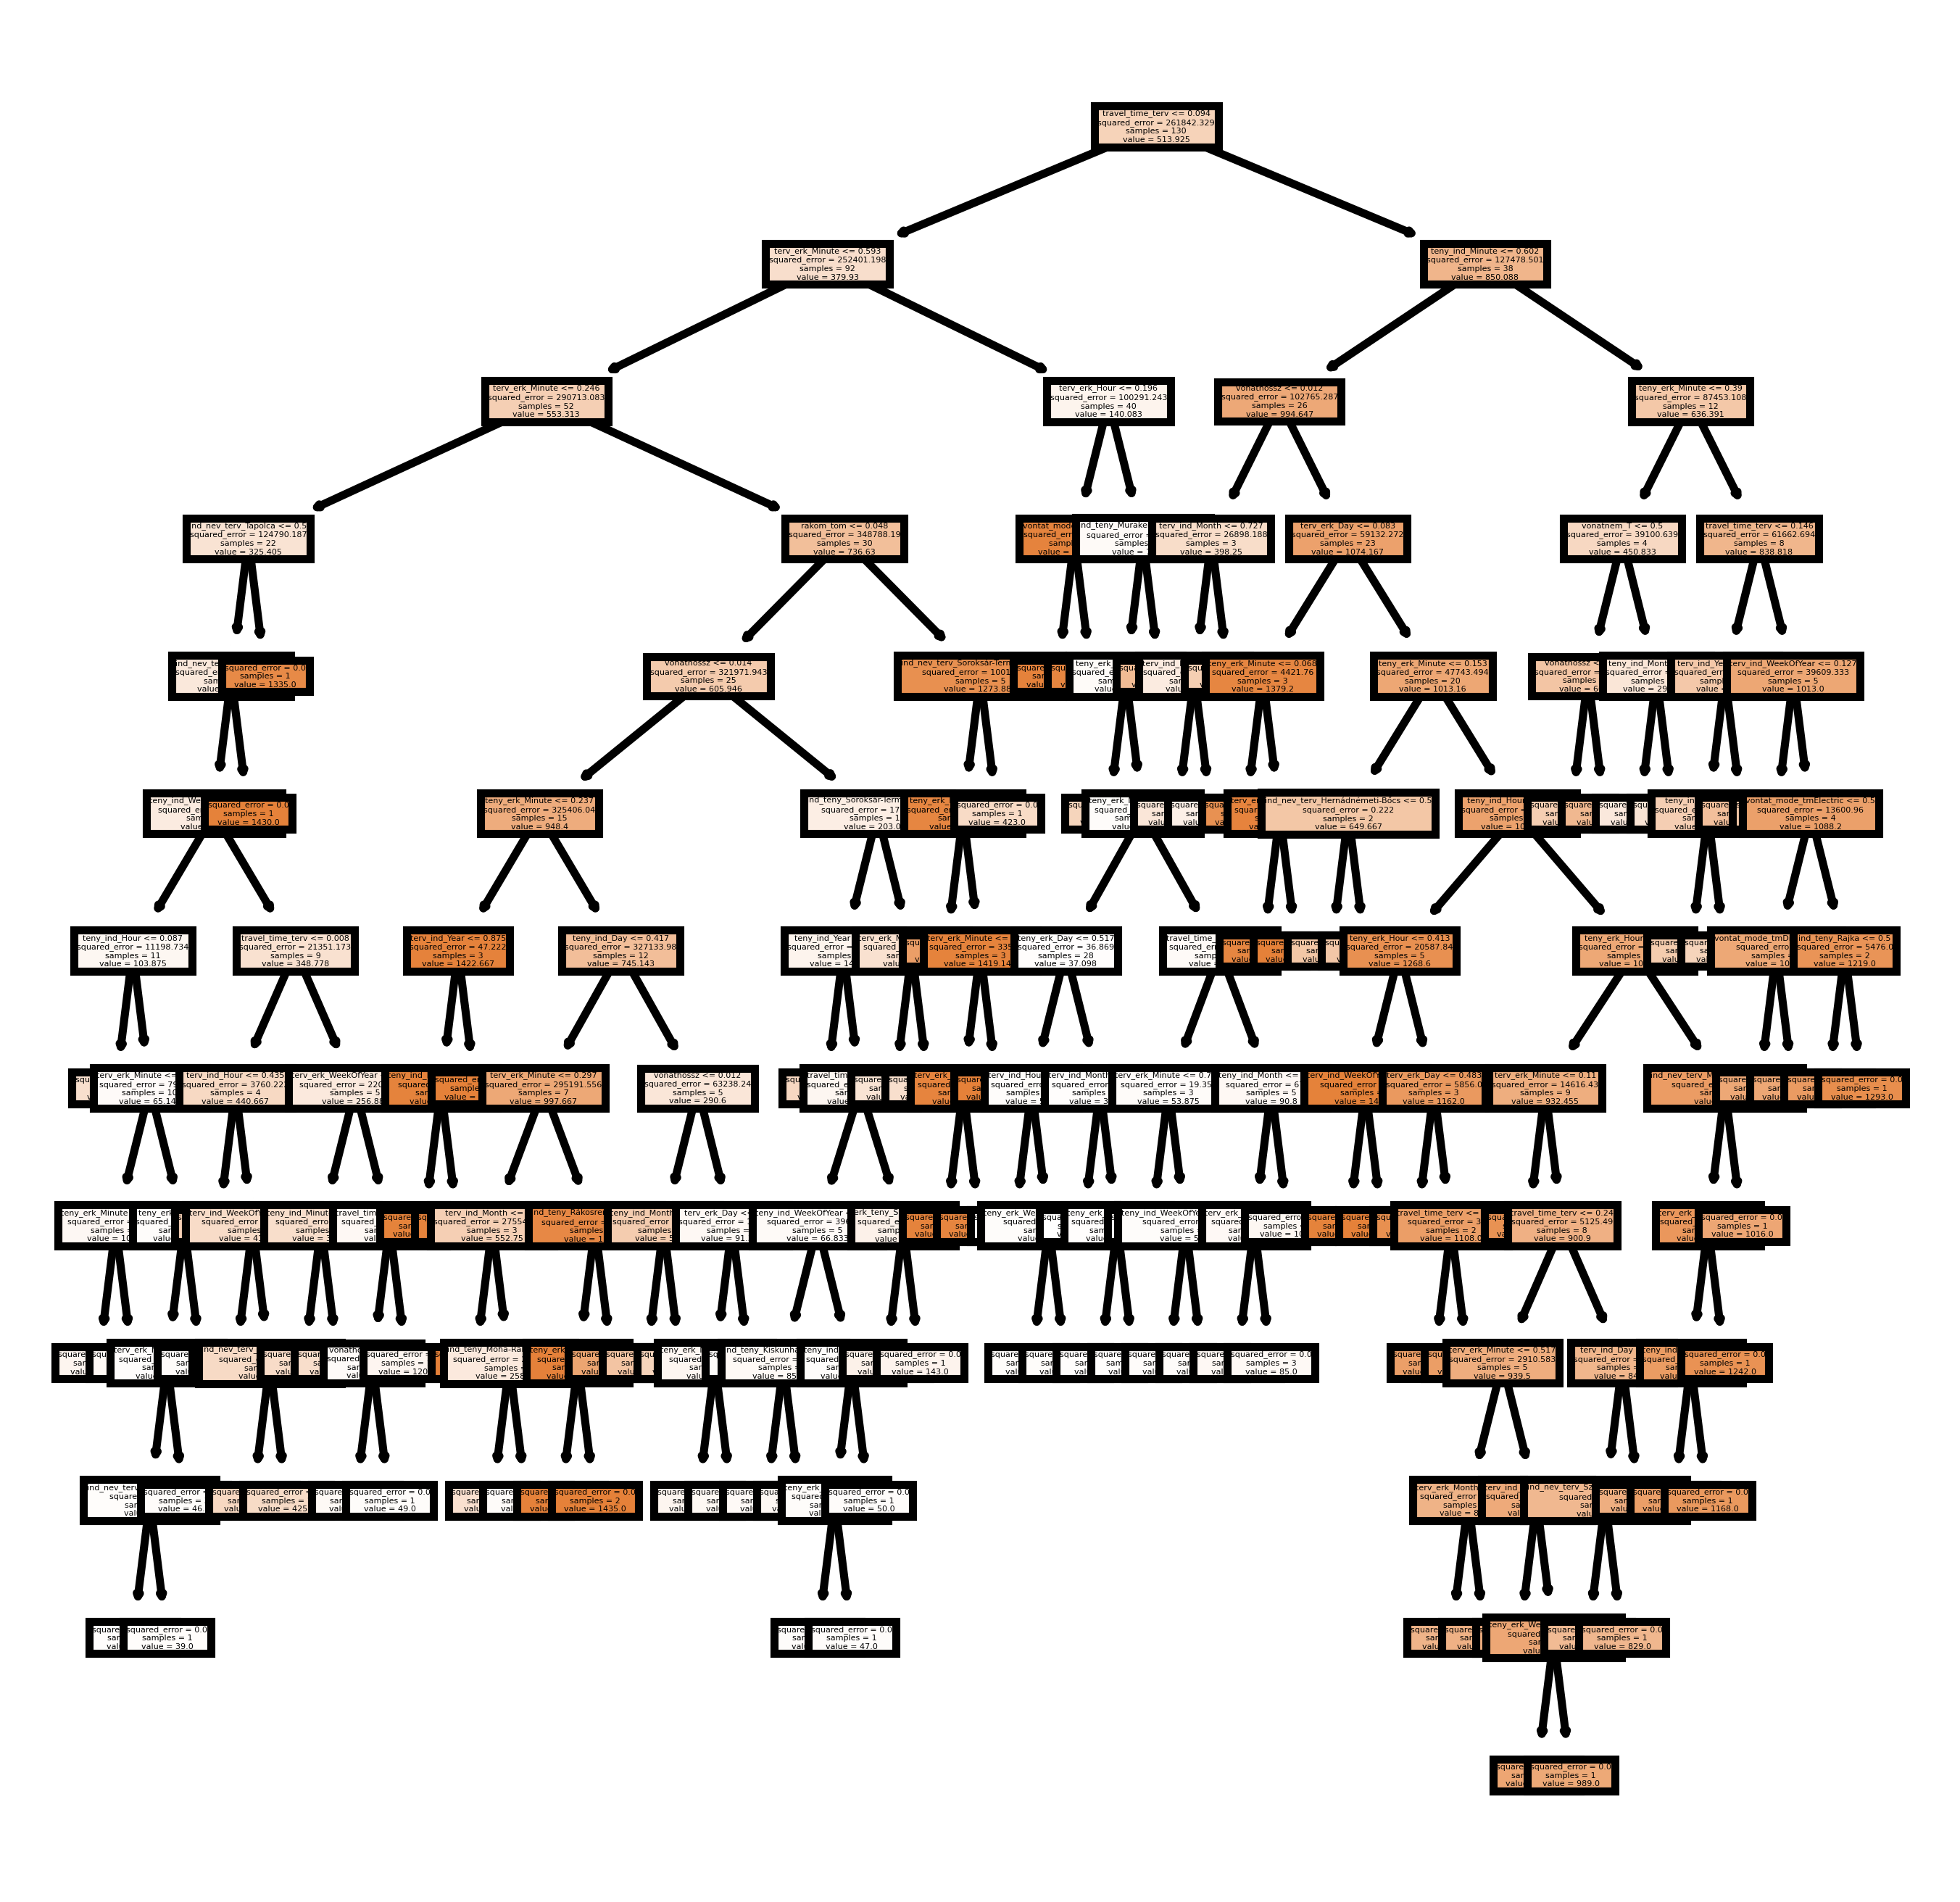

In [306]:
from sklearn import tree
fn=X_test.columns
cn=y.columns
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(model.estimators_[0],
               feature_names = fn,
               class_names=cn,
               filled = True);
fig.savefig('rf_individualtree.png')

In [307]:

print("tanuló adatokra XGBRegressor")
print("mse: ",xgbRegressorTrainMSE)
print("mae: ",xgbRegressorTrainMAE)

print("\n")

print("teszt adatokra XGBRegressor")
print("mse: ",xgbRegressorTestMSE)
print("mae: ",xgbRegressorTestMAE)

print("\n")

print("tanuló adatokra XGBRegressor fontosabb oszlopai")
print("mse: ",xgbRegressorImportantTrainMSE)
print("mae: ",xgbRegressorImportantTrainMAE)

print("\n")

print("tanuló adatokra XGBRegressor + GridSearch + Hyperparameter tunning")
print("mse: ",xgbRegressorGsHptTrainMSE)
print("mae: ",xgbRegressorGsHptTrainMAE)

print("\n")

print("teszt adatokra XGBRegressor + GridSearch + Hyperparameter tunning")
print("mse: ",xgbRegressorGsHptTestMSE)
print("mae: ",xgbRegressorGsHptTestMAE)

print("\n")

print("tanuló adatokra RandomForestRegressor")
print("mse: ",randomForestRegressorTrainMSE)
print("mae: ",randomForestRegressorTrainMSE)

print("\n")

print("teszt adatokra RandomForestRegressor")
print("mse: ",randomForestRegressorTestMSE)
print("mae: ",randomForestRegressorTestMAE)

print("\n")

print("tanuló adatokra RandomForestRegressor + GridSearch + Hyperparameter tunning")
print("mse: ",randomForestRegressorGsHptTrainMSE)
print("mae: ",randomForestRegressorGsHptTrainMAE)

print("\n")

print("teszt adatokra RandomForestRegressor + GridSearch + Hyperparameter tunning")
print("mse: ",randomForestRegressorGsHptTestMSE)
print("mae: ",randomForestRegressorGsHptTestMAE)

print("\n")

print("Az összes adatra RandomForestRegressor + GridSearch + Hyperparameter tunning")
print("mse: ",randomForestTreeGsHptAllMSE)
print("mae: ",randomForestTreeGsHptAllMAE)

tanuló adatokra XGBRegressor
mse:  1168.4421161571845
mae:  24.893870326450894


teszt adatokra XGBRegressor
mse:  161078.73853746953
mae:  264.88161481221516


tanuló adatokra XGBRegressor fontosabb oszlopai
mse:  942.8305019878117
mae:  22.114049516405377


tanuló adatokra XGBRegressor + GridSearch + Hyperparameter tunning
mse:  1.7583497537998483e-07
mae:  0.0003371783665248326


teszt adatokra XGBRegressor + GridSearch + Hyperparameter tunning
mse:  312571.0148250304
mae:  370.20998058319094


tanuló adatokra RandomForestRegressor
mse:  30066.601533571433
mae:  30066.601533571433


teszt adatokra RandomForestRegressor
mse:  129741.77024666667
mae:  248.45066666666668


tanuló adatokra RandomForestRegressor + GridSearch + Hyperparameter tunning
mse:  29642.010822930726
mae:  124.31231366737597


teszt adatokra RandomForestRegressor + GridSearch + Hyperparameter tunning
mse:  991.8673044794182
mae:  24.481995872527776


Az összes adatra RandomForestRegressor + GridSearch + Hyperparam